<a href="https://colab.research.google.com/github/schokoro/AttentionNMT/blob/dev/en_jap_translate.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Первым делом проверим какая карточка нам досталась. Лучшим вариантом будет `Tesla P100-PCIE-16GB`, на остальных будет считаться медленнее.

In [1]:
import torch
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
if device.type == 'cpu':
    raise RuntimeError
else:
    print(torch.cuda.get_device_name(0))

Tesla P100-PCIE-16GB


In [2]:
!pip install janome pandarallel  > /dev/null

In [3]:
!rm -rf AttentionNMT/
!git clone -b dev https://github.com/schokoro/AttentionNMT.git > /dev/null

Cloning into 'AttentionNMT'...
remote: Enumerating objects: 55, done.
remote: Counting objects: 100% (55/55), done.
remote: Compressing objects: 100% (41/41), done.
remote: Total 55 (delta 29), reused 28 (delta 13), pack-reused 0
Unpacking objects: 100% (55/55), done.


In [4]:
import sys
sys.path.append('/content/AttentionNMT')

In [5]:
%load_ext autoreload
%autoreload 2
import AttentionNMT
from AttentionNMT.transformer import Transformer, Encoder, Decoder
from AttentionNMT.utils import count_parameters, initialize_weights, translate_sentence, evaluate_blue, train, evaluate, display_attention, sentence_blue

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [6]:
%autoreload 2
from typing import Dict, List, Optional
import torch.nn as nn

from matplotlib.font_manager import FontProperties
from torchtext.data import Field, BucketIterator
from tqdm.notebook import tqdm
from pandarallel import pandarallel
import spacy
import warnings
import re
import random
import math
import time
from janome.tokenizer import Tokenizer as JTokenizer
import seaborn as sns
import numpy as np
import pandas as pd

sns.set()
tqdm.pandas()
warnings.filterwarnings('ignore')
pandarallel.initialize(progress_bar=False)

%matplotlib inline

INFO: Pandarallel will run on 2 workers.
INFO: Pandarallel will use Memory file system to transfer data between the main process and workers.


In [7]:
SEED = 42

random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
torch.backends.cudnn.deterministic = True

# Подготовка данных и EDA

Для обучения англо-японского переводчика будем использовать [Tanaka Corpus](http://www.edrdg.org/wiki/index.php/Tanaka_Corpus). Прямая ссылка на скачивание [здесь](ftp://ftp.monash.edu/pub/nihongo/examples.utf.gz).


In [8]:
!wget -q ftp://ftp.monash.edu/pub/nihongo/examples.utf.gz 
!gunzip -f examples.utf.gz

## Подготовка корпуса

Посмотрим, как выглядит корпус:

In [9]:
!head -4 examples.utf

A: ムーリエルは２０歳になりました。	Muiriel is 20 now.#ID=1282_4707
B: は 二十歳(はたち){２０歳} になる[01]{になりました}
A: すぐに戻ります。	I will be back soon.#ID=1284_4709
B: 直ぐに{すぐに} 戻る{戻ります}


Нам нужны только строки с префиксом `A:`
Для токенизации английского языка будем использовать spacy, для японского - токенизатор janome. Для англо-японского перевода будет лучше, если японский текст мы развернём задом наперёд. Просто поверьте. Или можете проверить. Соответственно, при переводе нам будет необходимо развернуть переведённый текст обратно.

In [10]:
reverse_src = False
reverse_trg = True

In [11]:
nlp = spacy.load("en_core_web_sm")
jt = JTokenizer()
en_remove = re.compile(r'#ID=.+')
is_token = re.compile(r'\w+')


def get_pair(line: str, reverse=reverse_src) -> Dict[str, str]:
    """
    Принимает на вход строку из файла паралелльного корпуса, возвращает словарь
     с японским и английским предложениями
    """
    jap, en = line.strip().split('\t')
    jap = jap.replace('A: ', '').strip()
    en = en_remove.sub('', en)
    return {'en': en, 'jap': jap}
  
def src_tokenize(text: str, reverse=reverse_src) -> List[str]:
    """
    Токенизирует английский текст, возвращает список токенов.
    """
    tokens = [tok.text for tok in nlp.tokenizer(text)]
    if reverse:
        tokens.reverse()
    return tokens


def trg_tokenize(text: str, reverse=reverse_trg) -> List[str]:
    """
    Токенизирует японский текст, возвращает список токенов в обратном порядке

    """
    tokens = [token.base_form for token in jt.tokenize(text)][: : -1]
    if reverse:
        tokens.reverse()
    return tokens


dicts = []
with open('examples.utf', 'r') as fobj:
    for i, line in enumerate(fobj):
        if line.startswith('A:'):
            dicts.append(get_pair(line))


corpus_df = pd.DataFrame(dicts)   

Посчитаем длины предложений в символах и посмотрим их корреляцию.

In [12]:
corpus_df['en_len'] = corpus_df['en'].map(lambda x: len(x))
corpus_df['jap_len'] = corpus_df['jap'].map(lambda x: len(x))

In [13]:
corpus_df[['en_len','jap_len' ]].corr()

,en_len,jap_len
en_len,1.000000,0.809457
jap_len,0.809457,1.000000


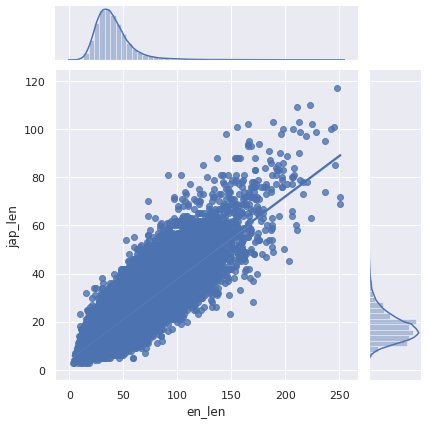

In [14]:
sns.jointplot("en_len", "jap_len", data=corpus_df, kind="reg");

А теперь - длины предложений в токенах и их корреляцию.

In [15]:
%time corpus_df['en_tok_len'] = corpus_df['en'].parallel_apply(lambda x: len(src_tokenize(x)))

CPU times: user 55.7 ms, sys: 102 ms, total: 158 ms
Wall time: 6.8 s


In [16]:
%time corpus_df['jap_tok_len'] = corpus_df['jap'].parallel_apply(lambda x: len(trg_tokenize(x)))

CPU times: user 143 ms, sys: 127 ms, total: 270 ms
Wall time: 2min 43s


In [17]:
corpus_df[['en_tok_len','jap_tok_len' ]].corr()

,en_tok_len,jap_tok_len
en_tok_len,1.000000,0.775549
jap_tok_len,0.775549,1.000000


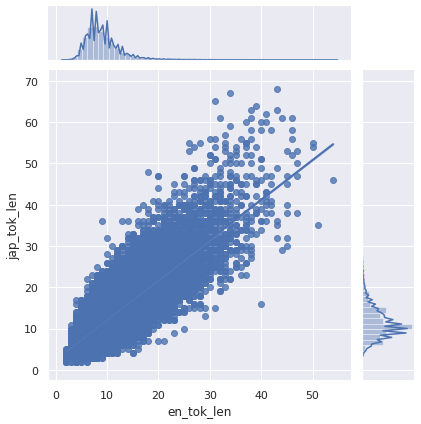

In [18]:
sns.jointplot("en_tok_len", "jap_tok_len", data=corpus_df, kind="reg")

In [19]:
corpus_df.describe()

,en_len,jap_len,en_tok_len,jap_tok_len
count,149791.000000,149791.000000,149791.000000,149791.000000
mean,40.471270,18.378407,9.307989,11.744270
std,17.417855,7.237879,3.594693,4.449102
min,3.000000,3.000000,2.000000,2.000000
25%,29.000000,14.000000,7.000000,9.000000
50%,37.000000,17.000000,9.000000,11.000000
75%,47.000000,21.000000,11.000000,14.000000
max,251.000000,117.000000,54.000000,68.000000


Выбросим из корпуса предложения длиннее чем `quantile(0.9)` и сохраним в файл.

In [20]:
corpus_df.en_tok_len.quantile(0.9), corpus_df.jap_tok_len.quantile(0.9)

(13.0, 17.0)

In [21]:
new_corpus_df = corpus_df[
    (corpus_df.en_tok_len < corpus_df.en_tok_len.quantile(0.9)) &
    (corpus_df.jap_tok_len < corpus_df.jap_tok_len.quantile(0.9)) 
]
corpus_df.shape

(149791, 6)

In [22]:
new_corpus_df.to_csv('en_jap_corpus.csv', index=None, columns=['en', 'jap'])

In [23]:
max_src = corpus_df.en_tok_len.max() + 2
max_trg = corpus_df.jap_tok_len.max() + 2

In [24]:
SRC = Field(
            tokenize = src_tokenize, 
            init_token = '<sos>', 
            eos_token = '<eos>', 
            lower = True, 
            batch_first = True)

TRG = Field(
            tokenize = trg_tokenize, 
            init_token = '<sos>', 
            eos_token = '<eos>', 
            lower = True, 
            batch_first = True)

In [25]:
%%time
trn_data_fields = [("src", SRC), ("trg", TRG)]

dataset = torchtext.data.TabularDataset(
    path='en_jap_corpus.csv',
    format='csv',
    skip_header=True,
    fields=trn_data_fields
)

CPU times: user 2min 38s, sys: 585 ms, total: 2min 38s
Wall time: 2min 38s


In [26]:
train_data, valid_data, test_data = dataset.split(split_ratio=[0.98, 0.01, 0.01])

In [27]:
SRC.build_vocab(train_data.src, min_freq=3)  # 
print(SRC.vocab.freqs.most_common(10))

TRG.build_vocab(train_data.trg, min_freq=3)
print(TRG.vocab.freqs.most_common(10))

print(f'SRC.vocab: {len(SRC.vocab)}, TRG.vocab: {len(TRG.vocab)}')

[('.', 110945), ('the', 47508), ('to', 26425), ('i', 25461), ('a', 21923), ('is', 20993), ('he', 19826), ('you', 15670), ('of', 14218), ('in', 13554)]
[('。', 121263), ('は', 93010), ('た', 51259), ('の', 48574), ('に', 48356), ('を', 47677), ('て', 34193), ('が', 30261), ('する', 27333), ('だ', 25724)]
SRC.vocab: 9050, TRG.vocab: 11167


In [28]:
BATCH_SIZE = 256

train_iterator, valid_iterator, test_iterator = BucketIterator.splits(
    (train_data, valid_data, test_data),
    batch_size=BATCH_SIZE,
    sort_key=lambda x: len(x.src), # the BucketIterator needs to be told what function it should use to group the data.
    sort_within_batch=False,
    shuffle=True,
    device=device)

## Training the Transformer Model

We can now define our encoder and decoders. This model is significantly smaller than Transformers used in research today, but is able to be run on a single GPU quickly.

In [29]:
INPUT_DIM = len(SRC.vocab)
OUTPUT_DIM = len(TRG.vocab)
HID_DIM = 128
ENC_LAYERS = 3
DEC_LAYERS = 3
ENC_HEADS = 4
DEC_HEADS = 4
ENC_PF_DIM = 2 * HID_DIM
DEC_PF_DIM = 2 * HID_DIM
ENC_DROPOUT = 0.07
DEC_DROPOUT = 0.07

enc = Encoder(INPUT_DIM, 
              HID_DIM, 
              ENC_LAYERS, 
              ENC_HEADS, 
              ENC_PF_DIM, 
              dropout=ENC_DROPOUT, 
              device=device,
              max_length=max_src)

dec = Decoder(OUTPUT_DIM, 
              HID_DIM, 
              DEC_LAYERS, 
              DEC_HEADS, 
              DEC_PF_DIM,
              dropout=DEC_DROPOUT, 
              device=device,
              max_length=max_trg)

Then, use them to define our whole sequence-to-sequence encapsulating model.

In [30]:
SRC_PAD_IDX = SRC.vocab.stoi[SRC.pad_token]
TRG_PAD_IDX = TRG.vocab.stoi[TRG.pad_token]
try:
    del model
    torch.cuda.empty_cache()
except:
    print('no model')

model = Transformer(enc, dec, SRC_PAD_IDX, TRG_PAD_IDX, device).to(device)

no model


We can check the number of parameters, noticing it is significantly less than the 37M for the convolutional sequence-to-sequence model.

In [31]:
print(f'The model has {count_parameters(model):,} trainable parameters')

The model has 5,035,935 trainable parameters


The paper does not mention which weight initialization scheme was used, however Xavier uniform seems to be common amongst Transformer models, so we use it here.

The optimizer used in the original Transformer paper uses Adam with a learning rate that has a "warm-up" and then a "cool-down" period. BERT and other Transformer models use Adam with a fixed learning rate, so we will implement that. Check [this](http://nlp.seas.harvard.edu/2018/04/03/attention.html#optimizer) link for more details about the original Transformer's learning rate schedule.

Note that the learning rate needs to be lower than the default used by Adam or else learning is unstable.

We then define a small function that we can use to tell us how long an epoch takes.

In [32]:
def epoch_time(start_time, end_time):
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
    return elapsed_mins, elapsed_secs

In [33]:
model.apply(initialize_weights);
best_macro_bleu = 0
test_loss = np.inf

In [34]:
BEST_MODEL = 'best_blue_en_jap.pt'

In [35]:
cross_entropy = nn.CrossEntropyLoss(ignore_index = TRG_PAD_IDX)
LEARNING_RATE = 1.25e-3
optimizer = torch.optim.Adam(model.parameters(), lr = LEARNING_RATE)

def criterion(pred, target):
    """
    pred - BatchSize x TargetLen x VocabSize
    target - BatchSize x TargetLen
    """
    pred_flat = pred.view(-1, pred.shape[-1])  # BatchSize*TargetLen x VocabSize
    target_flat = target.view(-1)  # BatchSize*TargetLen
    return cross_entropy(pred_flat, target_flat)

scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer=optimizer,
                                                       factor=0.2,
                                                       verbose=True,
                                                       cooldown=0, 
                                                       patience=4,              
                                                       threshold=0.01,
                                                       min_lr=5e-5)

In [36]:
train_history = []
valid_history = []
blue_history = []

In [37]:
N_EPOCHS = 25
CLIP = 1

try:
    best_valid_loss = evaluate(model, valid_iterator, criterion)
except:
    best_valid_loss = float('inf')
print(f'Loss: {best_valid_loss:7.3f}')


for epoc_num, epoch in tqdm(enumerate(range(N_EPOCHS)), total=N_EPOCHS):
    curent_lr = optimizer.param_groups[0]['lr']
    start_time = time.time()
    try:
        train_loss = train(model, train_iterator, optimizer, criterion, CLIP, 1, 1)
        valid_loss = evaluate(model, valid_iterator, criterion)
        
        scheduler.step(valid_loss)
                
        if valid_loss < best_valid_loss:
            best_valid_loss = valid_loss
            print('Новая лучшая модель')

        macro_bleu = evaluate_blue(valid_data, SRC, TRG, model, device, max_trg, src_tokenize)
        if macro_bleu > best_macro_bleu:
            best_macro_bleu = macro_bleu
            print('Новый лучший blue')            
            torch.save(model.state_dict(), BEST_MODEL)

        train_history.append(train_loss)
        valid_history.append(valid_loss)
        blue_history.append(macro_bleu)

        end_time = time.time()
        
        epoch_mins, epoch_secs = epoch_time(start_time, end_time)
        print(f'Epoch: {epoch+1:02} | Time: {epoch_mins}m {epoch_secs}s')
        
        print(f'\tMacro-average BLEU: {macro_bleu:.6f}')
        print(f'\tTrain Loss: {train_loss:.3f} | Train PPL: {math.exp(train_loss):7.3f}')
        print(f'\t Val. Loss: {valid_loss:.3f} |  Val. PPL: {math.exp(valid_loss):7.3f}')
        print('_' * 100)
    except KeyboardInterrupt:
        print(f"Epoch: {epoch+1:02} | LR: {optimizer.param_groups[0]['lr']}")
        break
    finally:
        pass

Loss:   9.331


Новая лучшая модель
Новый лучший blue
Epoch: 01 | Time: 2m 15s
	Macro-average BLEU: 0.631266
	Train Loss: 3.563 | Train PPL:  35.266
	 Val. Loss: 2.522 |  Val. PPL:  12.453
____________________________________________________________________________________________________
Новая лучшая модель
Новый лучший blue
Epoch: 02 | Time: 2m 13s
	Macro-average BLEU: 0.673567
	Train Loss: 2.319 | Train PPL:  10.163
	 Val. Loss: 1.949 |  Val. PPL:   7.021
____________________________________________________________________________________________________
Новая лучшая модель
Новый лучший blue
Epoch: 03 | Time: 2m 10s
	Macro-average BLEU: 0.693782
	Train Loss: 1.877 | Train PPL:   6.535
	 Val. Loss: 1.733 |  Val. PPL:   5.659
____________________________________________________________________________________________________
Новая лучшая модель
Новый лучший blue
Epoch: 04 | Time: 2m 11s
	Macro-average BLEU: 0.705336
	Train Loss: 1.624 | Train PPL:   5.075
	 Val. Loss: 1.618 |  Val. PPL:   5.042
_____

We load our "best" parameters and manage to achieve a better test perplexity than all previous models.

In [38]:
model.load_state_dict(torch.load(BEST_MODEL))

test_loss = evaluate(model, test_iterator, criterion)

print(f'| Test Loss: {test_loss:.3f} | Test PPL: {math.exp(test_loss):7.3f} |')

| Test Loss: 1.590 | Test PPL:   4.902 |


Для корректного отображения карт внимания загрузим шрифт `Osaka.ttf`. Хотя, можно взять и из репозитория.

In [39]:
!wget -q https://github.com/vuthaihoc/fonts/raw/master/JUSTRAJDEEP/Osaka.ttf

fontprop_x = FontProperties(size=20)
fontprop_y = FontProperties(fname='Osaka.ttf', size=20)

src      : i think it true .
trg      : 。 思う と だ 本当 が それ は 私
predicted: <eos> 。 思う と だ 本当 は それ
     blue: 82.98%


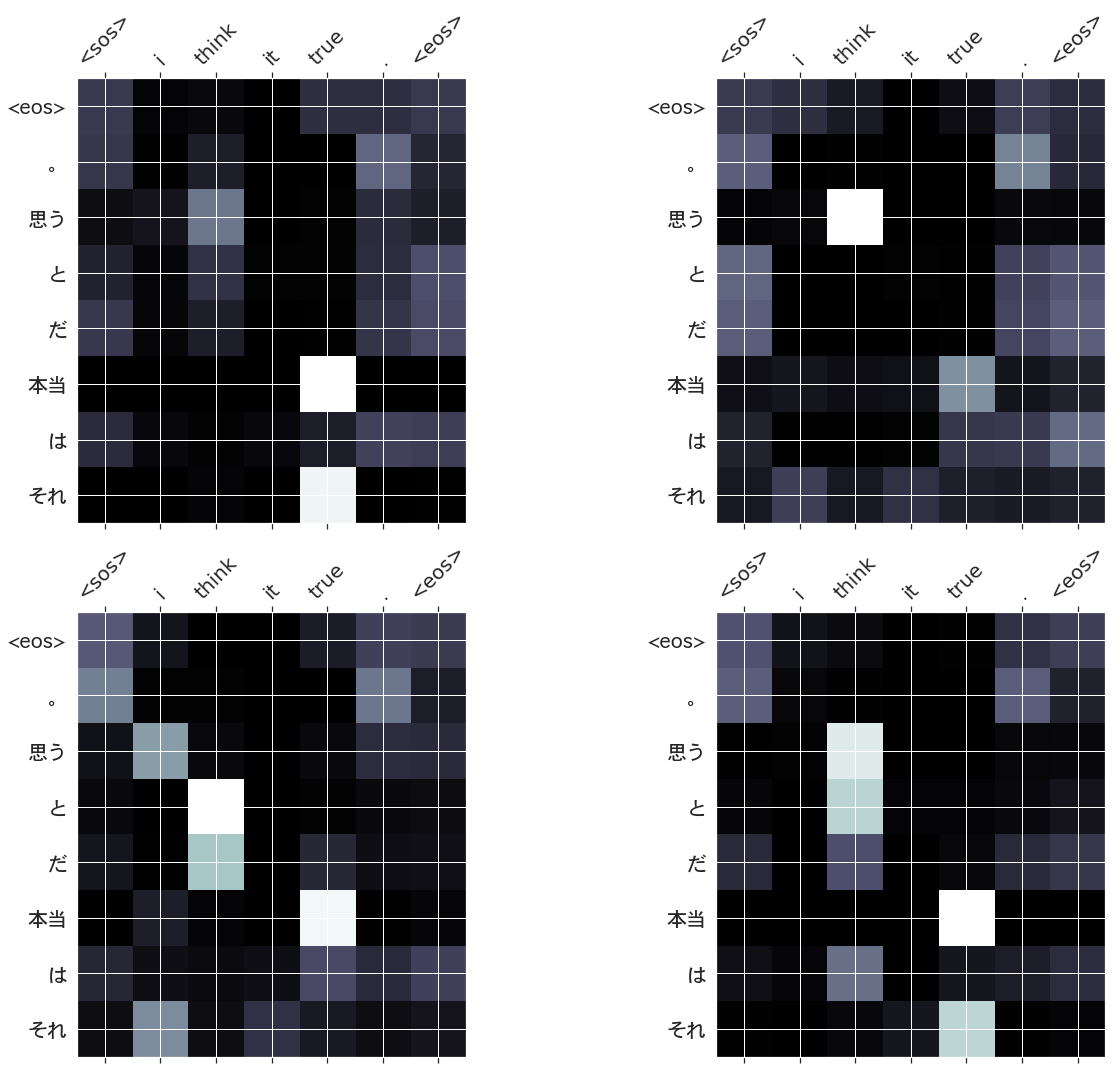

In [40]:
example_idx = random.randint(0, len(train_data) - 1)

src = vars(train_data.examples[example_idx])['src']
trg = vars(train_data.examples[example_idx])['trg']
translation, attention = translate_sentence(src, SRC, TRG, model, device, max_trg, src_tokenize)

print(f'src      : {" ".join(src)}')
print(f'trg      : {" ".join(trg[::-1])}')
print(f'predicted: {" ".join(translation[::-1])}')
print(f'     blue: {100 * sentence_blue(trg, translation):.2f}%')
display_attention(src, translation, attention, n_heads = DEC_HEADS, n_rows = DEC_HEADS/2, n_cols = 2, fontprop_x=fontprop_x, fontprop_y=fontprop_y, reverse_trg=True)

src      : i 'll never forget talking with him there .
trg      : 。 う です ない 忘れる 決して を の た 話す と 彼 そこで
predicted: <eos> 。 う だ ない する を 話 決して は で そこ と 彼
     blue: 81.36%


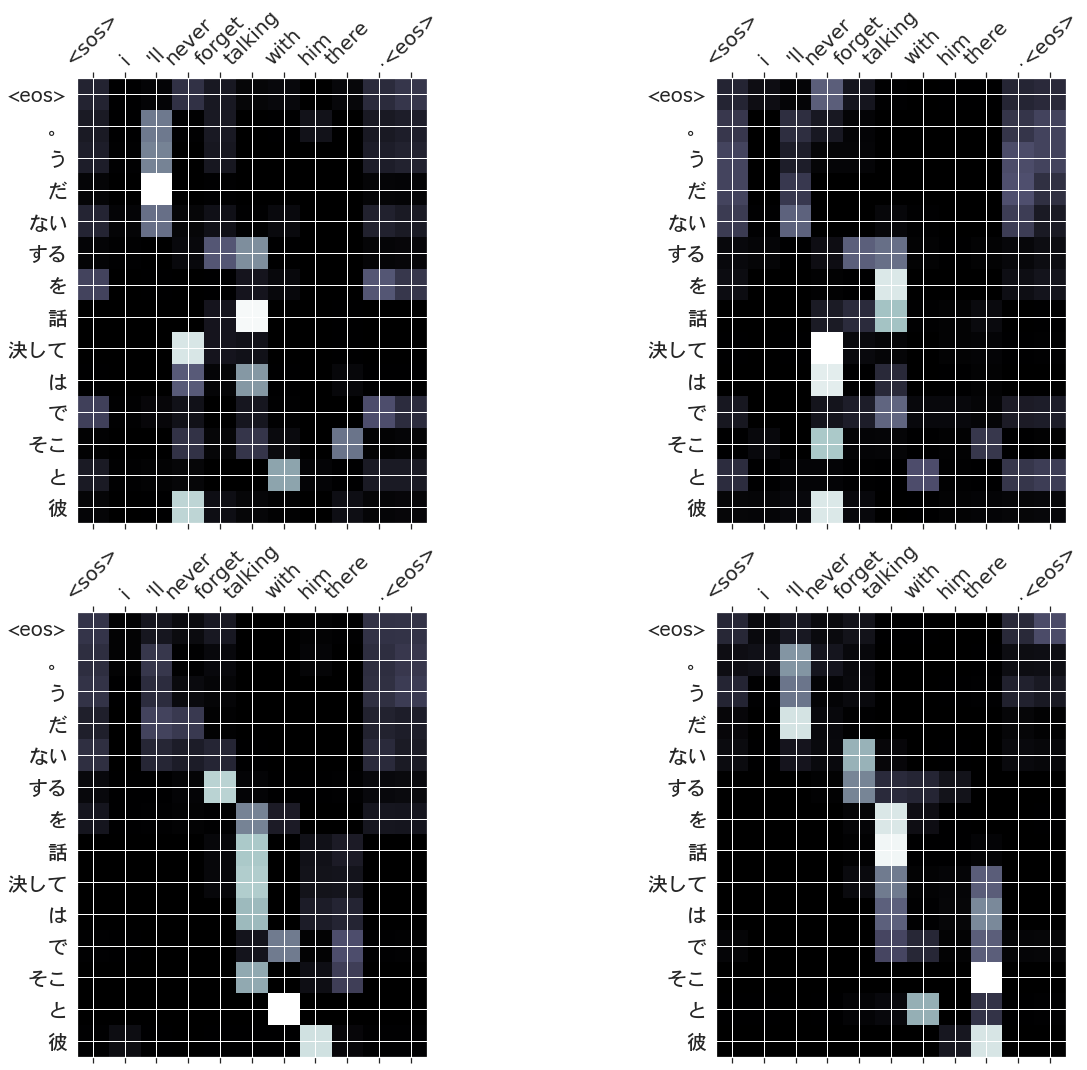

In [41]:
example_idx = random.randint(0, len(valid_data) - 1)

src = vars(valid_data.examples[example_idx])['src']
trg = vars(valid_data.examples[example_idx])['trg']
translation, attention = translate_sentence(src, SRC, TRG, model, device, max_trg, src_tokenize)

print(f'src      : {" ".join(src)}')
print(f'trg      : {" ".join(trg[::-1])}')
print(f'predicted: {" ".join(translation[::-1])}')
print(f'     blue: {100 * sentence_blue(trg, translation):.2f}%')
display_attention(src, translation, attention, n_heads = DEC_HEADS, n_rows = DEC_HEADS/2, n_cols = 2, fontprop_x=fontprop_x, fontprop_y=fontprop_y, reverse_trg=True)

src      : my life changed , sparked by meeting mr matsukawa .
trg      : 。 た 変わる は 人生 の 私 、 に きっかけ を 出会い の と 先生 松川
predicted: <eos> 。 た する <unk> によって 氏 <unk> は 人生 の 私
     blue: 76.89%


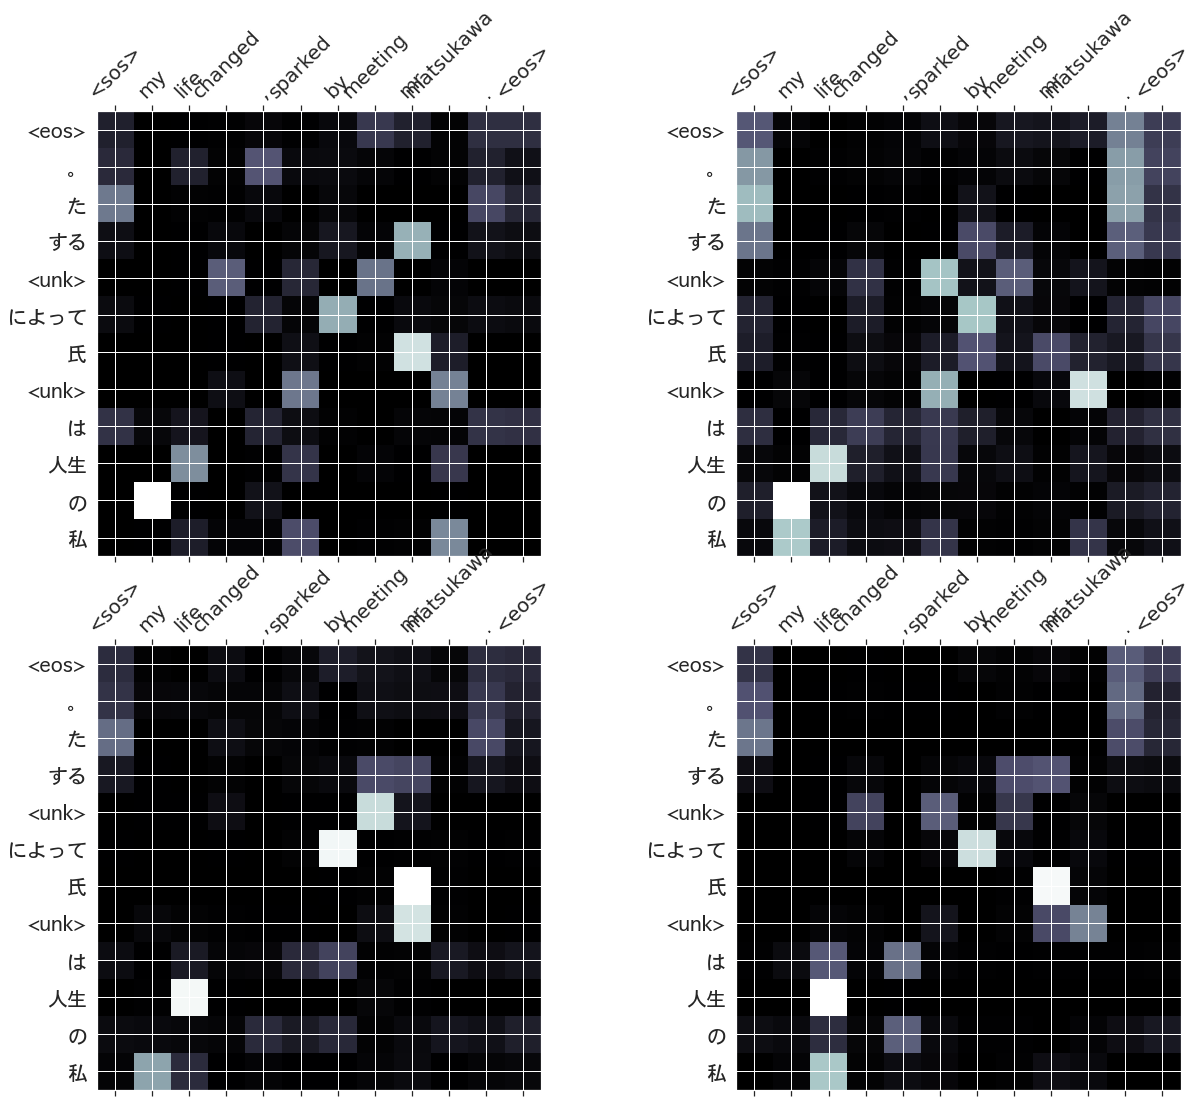

In [42]:
example_idx = random.randint(0, len(test_data) - 1)

src = vars(test_data.examples[example_idx])['src']
trg = vars(test_data.examples[example_idx])['trg']
translation, attention = translate_sentence(src, SRC, TRG, model, device, max_trg, src_tokenize)

print(f'src      : {" ".join(src)}')
print(f'trg      : {" ".join(trg[::-1])}')
print(f'predicted: {" ".join(translation[::-1])}')
print(f'     blue: {100 * sentence_blue(trg, translation):.2f}%')
display_attention(src, translation, attention, n_heads = DEC_HEADS, n_rows = DEC_HEADS/2, n_cols = 2, fontprop_x=fontprop_x, fontprop_y=fontprop_y, reverse_trg=True)

src      : all things considered , she is a fairly good wife .
trg      : 。 だ まあ まあ として 妻 は 彼女 、 と 入れる に 考慮 を すべて
predicted: <eos> 。 だ 妻 よい かなり は 彼女 、 と 考える を こと あらゆる
     blue: 85.66%


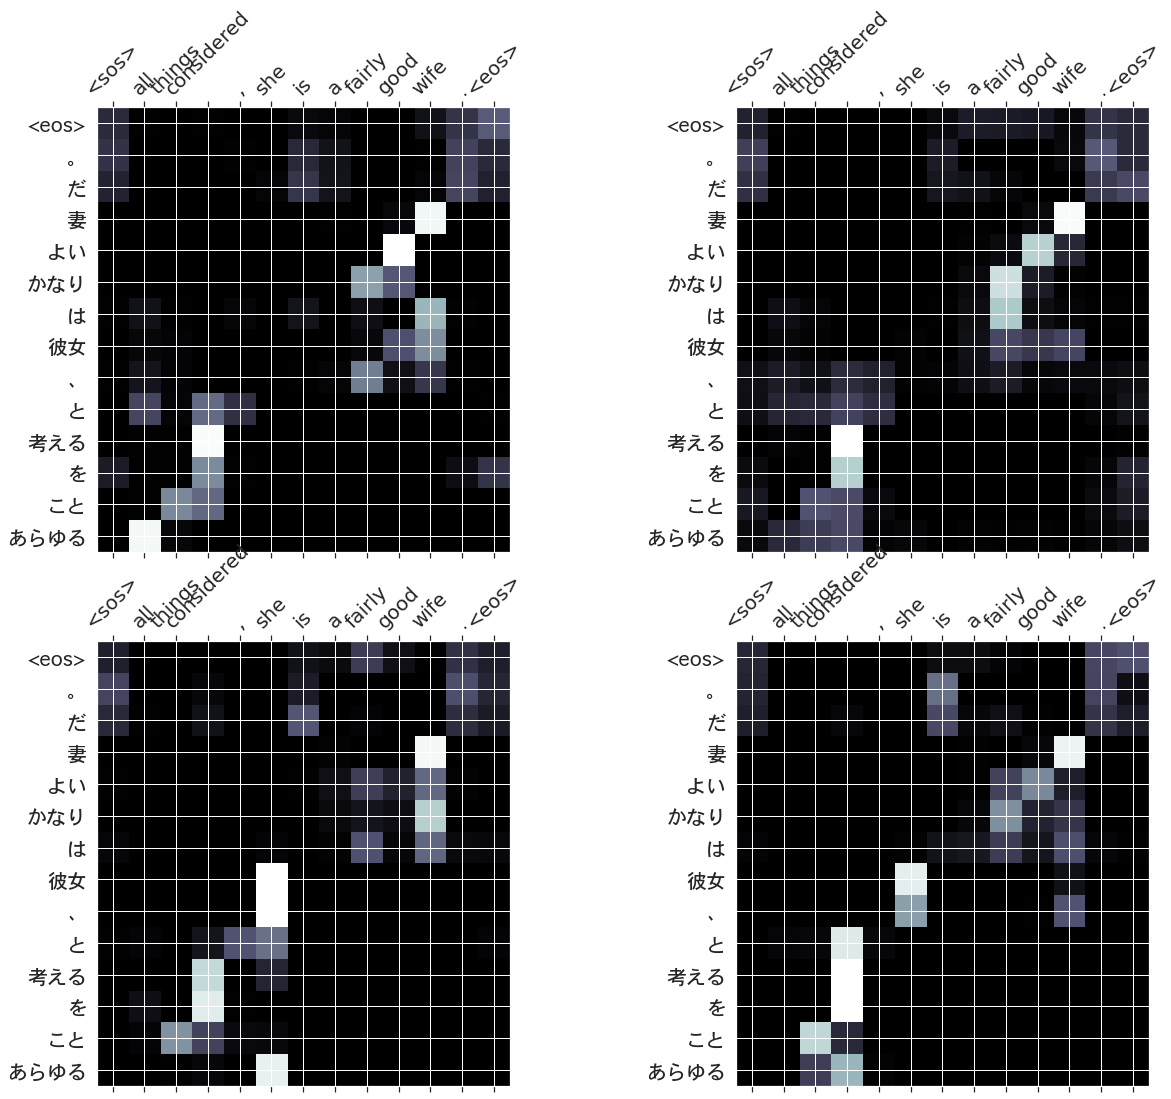

src      : we had few sunny days this summer .
trg      : 。 た ない ほとんど が 日 の 晴れ は 夏 の 今年
predicted: <eos> 。 た ある も 日 晴れ は 夏 の 今年
     blue: 88.01%


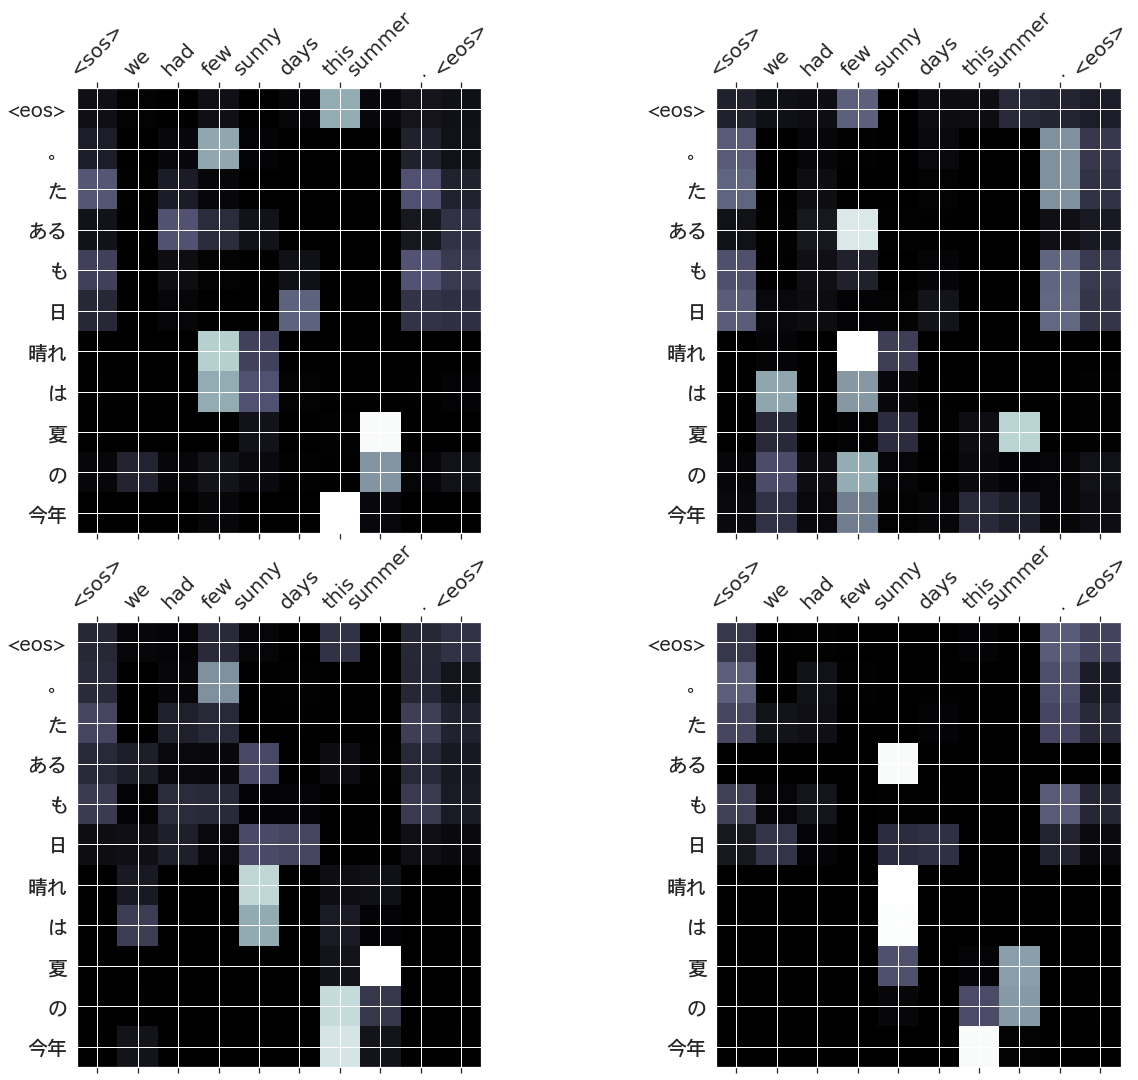

src      : the room was full of smoke .
trg      : 。 た だ いっぱい で 煙 は 部屋
predicted: <eos> 。 た だ いっぱい で 煙 は 部屋
     blue: 93.06%


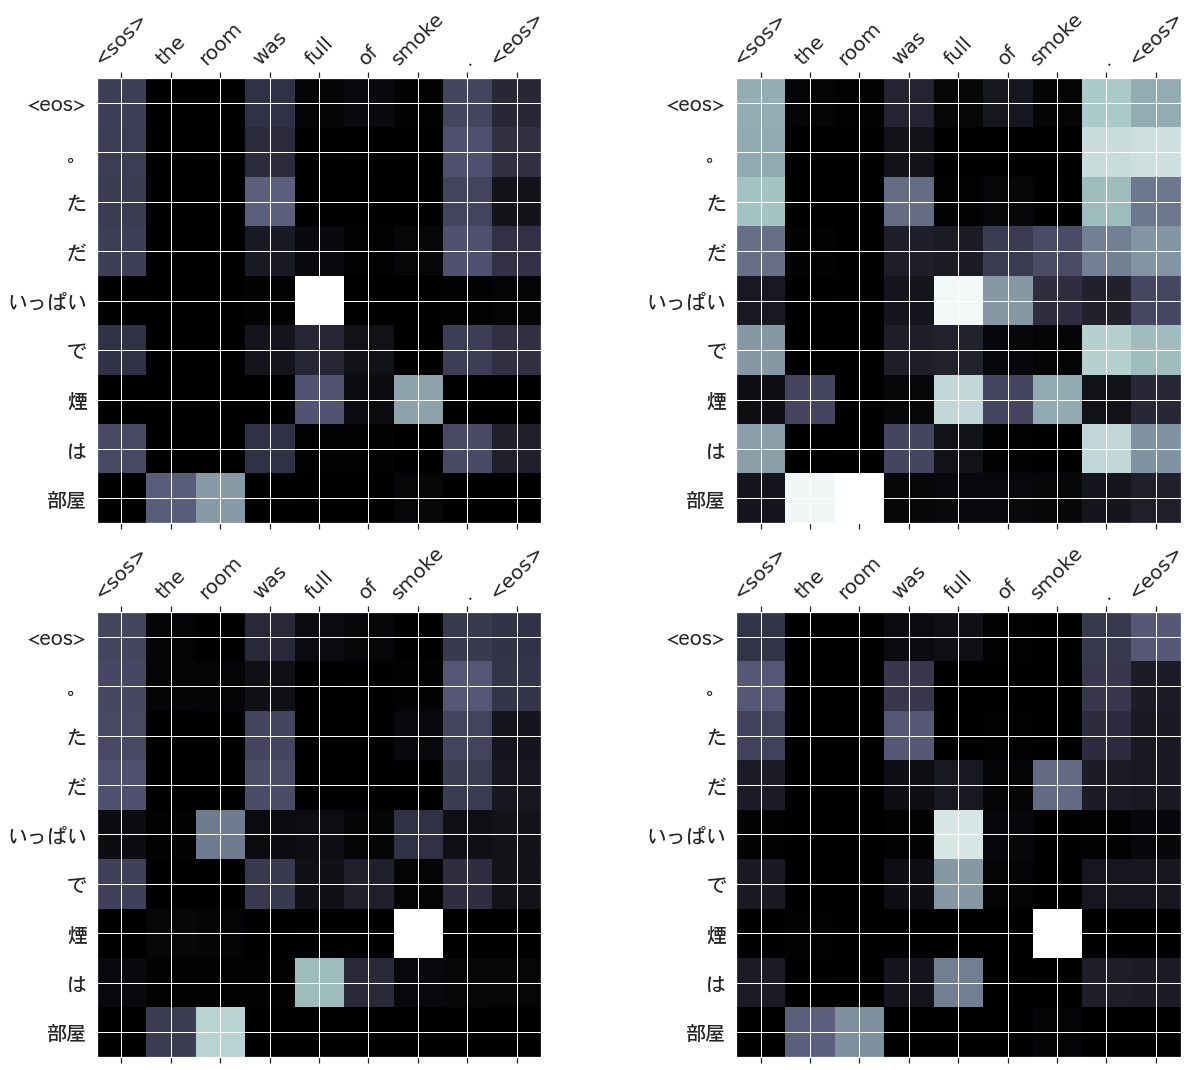

src      : i have never gone to america .
trg      : 。 ない が こと た いく に アメリカ は 私
predicted: <eos> 。 ない が こと た 行く に アメリカ は 私
     blue: 88.01%


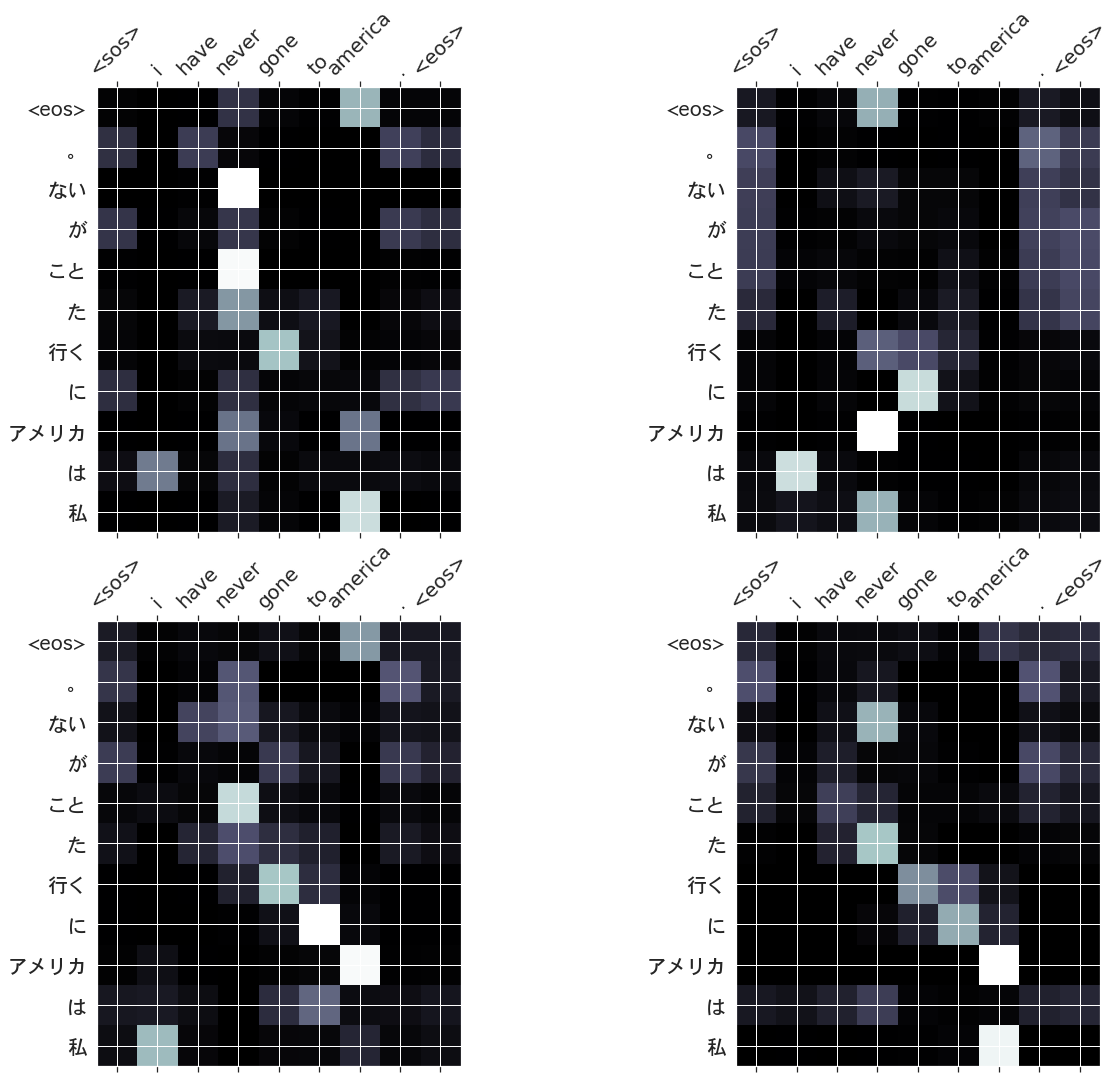

src      : i have never climbed mt. fuji .
trg      : 。 ない が こと た 登る に 富士山 まだ は 私
predicted: <eos> 。 ない が こと た 登る に 富士山 は 私
     blue: 88.01%


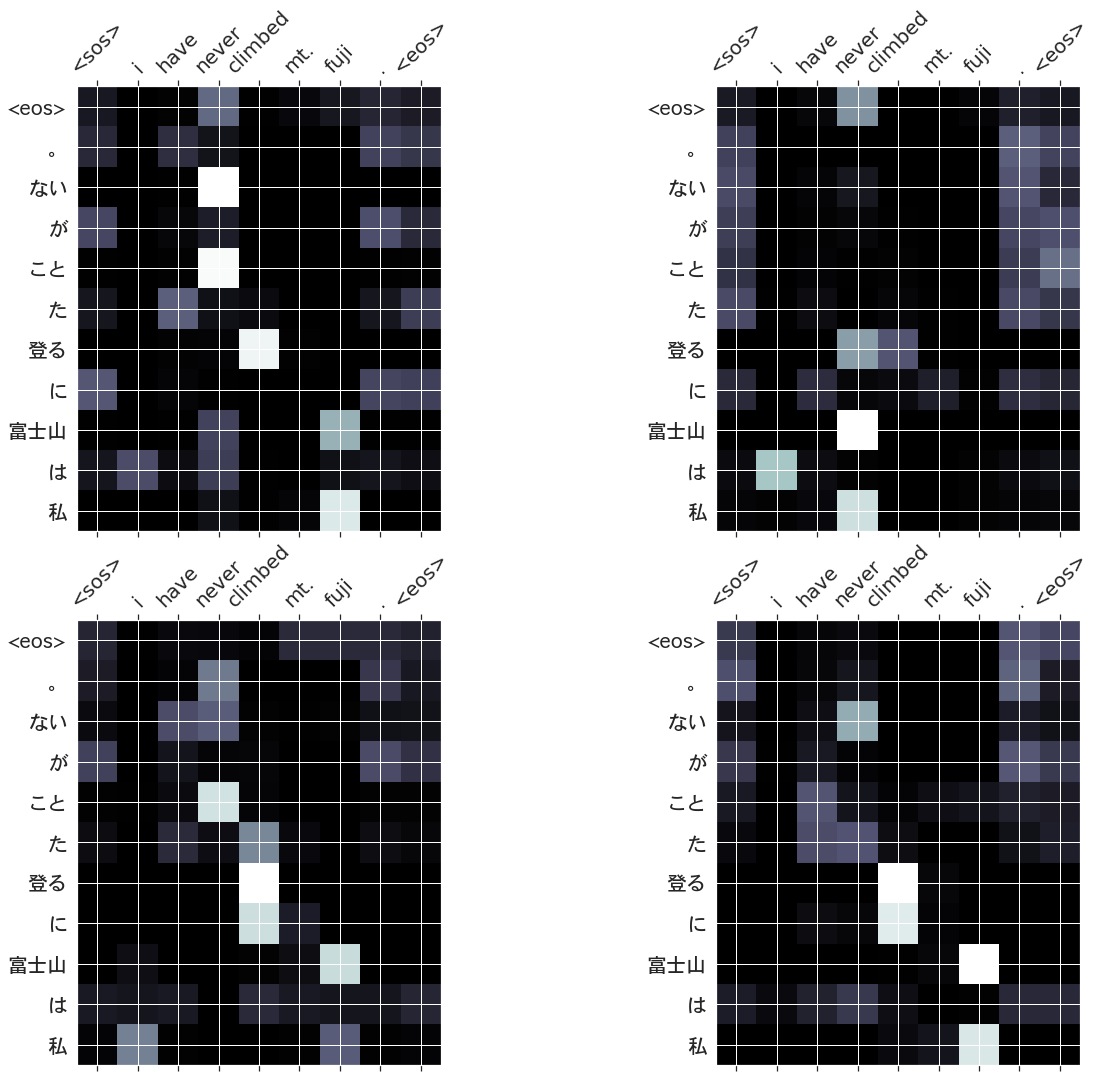

src      : michael caught her by the hand .
trg      : 。 た 捕まえる を 手 の 彼女 は マイケル
predicted: <eos> 。 た 捕まえる を 手 の 彼女 は マイケル
     blue: 90.36%


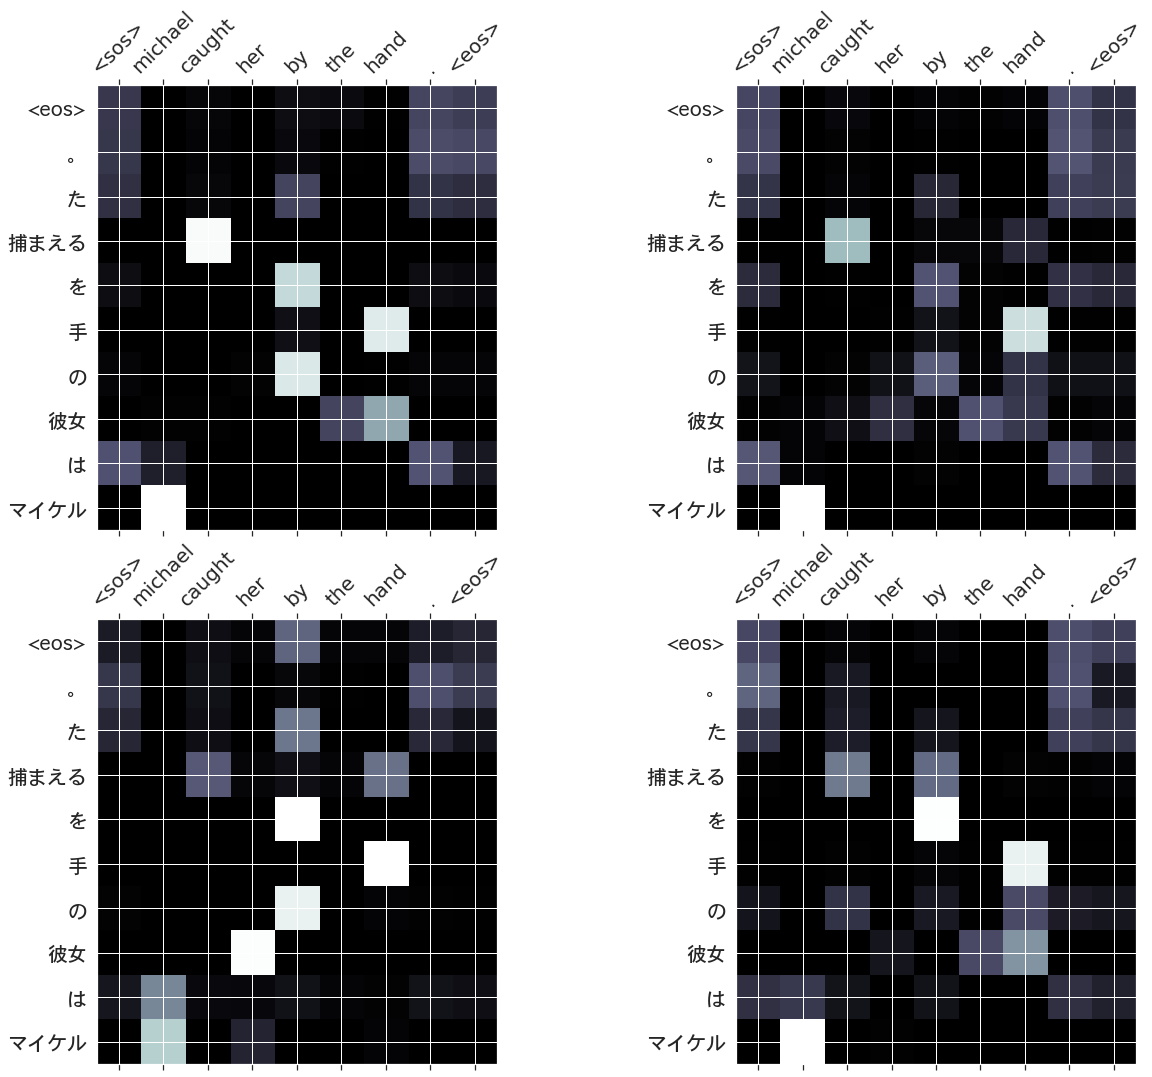

src      : it is bad manners to point at people .
trg      : 。 だ 無作法 は の 差す 指 を 人
predicted: <eos> 。 だ 無作法 は の 指さす を 人
     blue: 93.06%


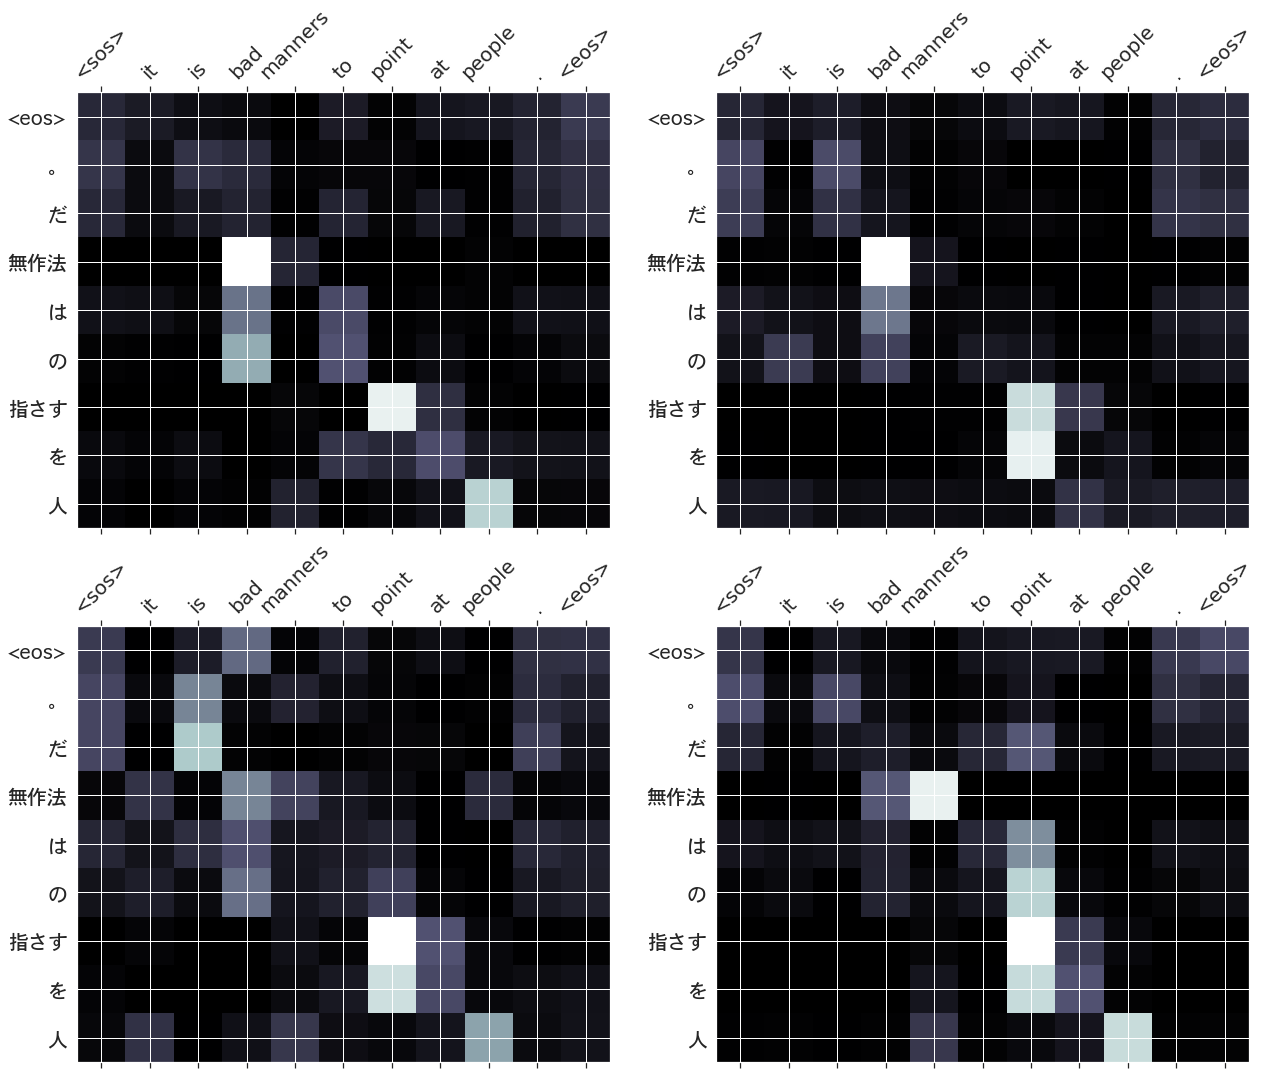

src      : i was very poor in those days .
trg      : 。 た だ 貧乏 に 非常 は 私 、 頃 その
predicted: <eos> 。 た 貧しい とても は 私 当時
     blue: 86.94%


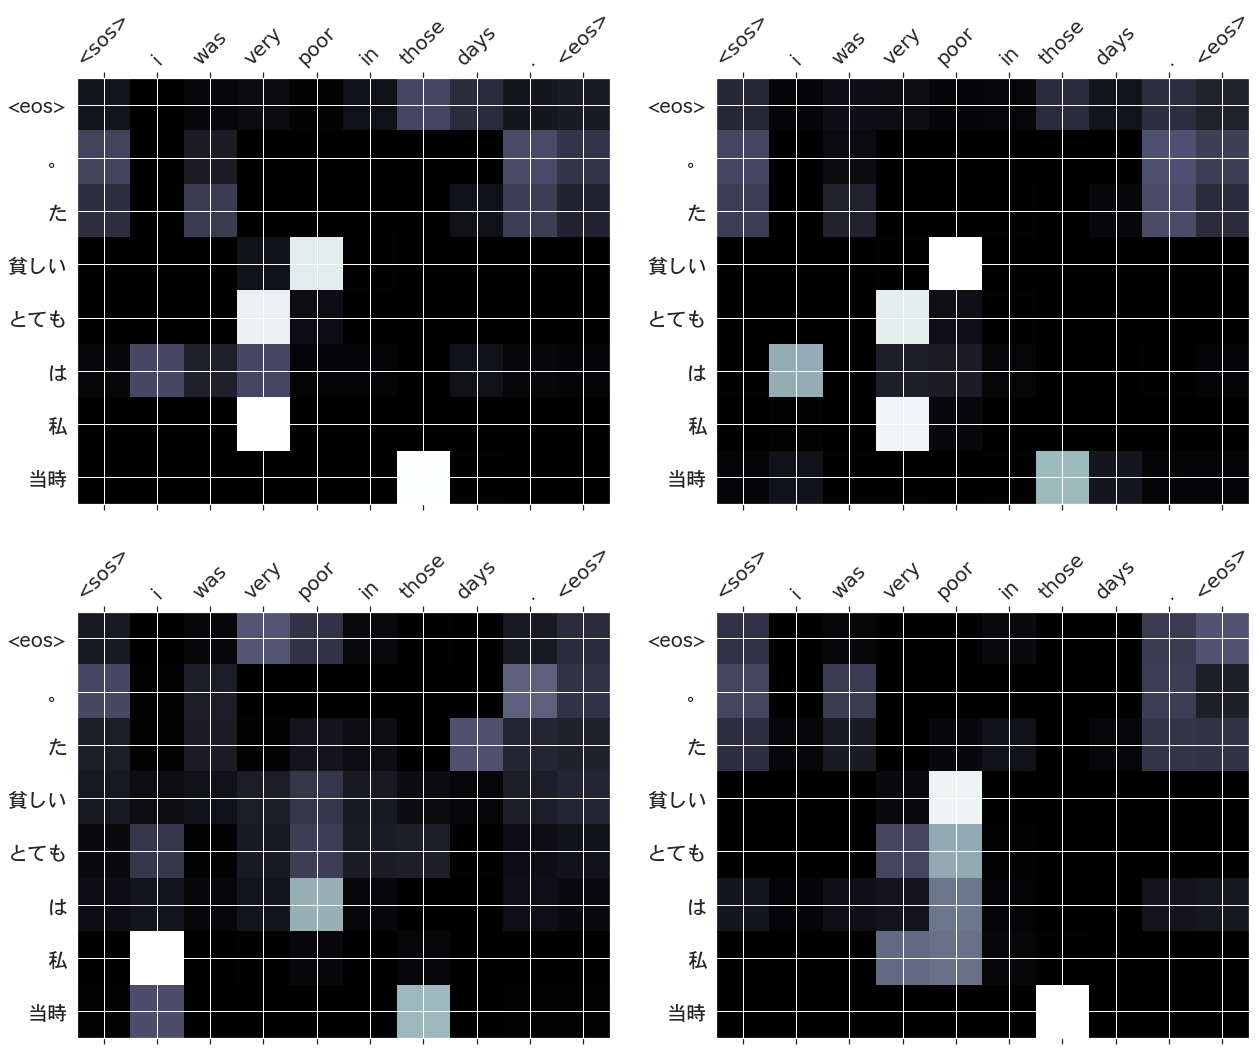

src      : how come you did n't come to the party ?
trg      : 。 か です の た ない 来る に パーティー は あなた 、 どうして
predicted: <eos> 。 か です の た 来る て やる どう は に パーティー
     blue: 87.39%


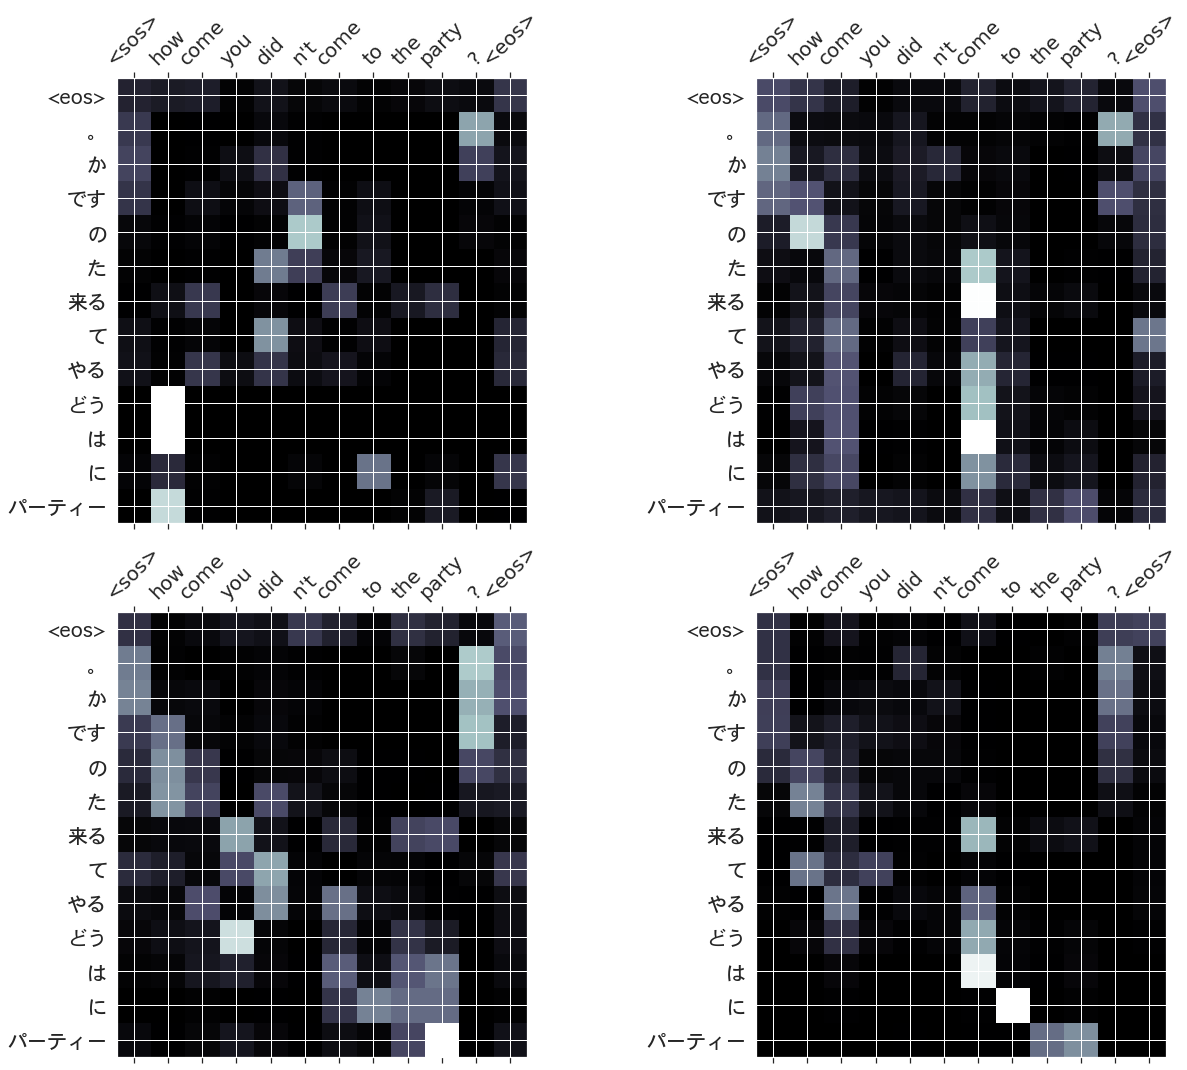

src      : to speak frankly i do n't like him .
trg      : 。 だ 嫌い が 彼 、 て 言う に 率直
predicted: <eos> 。 だ 嫌い は 彼 て 言う に 率直
     blue: 86.33%


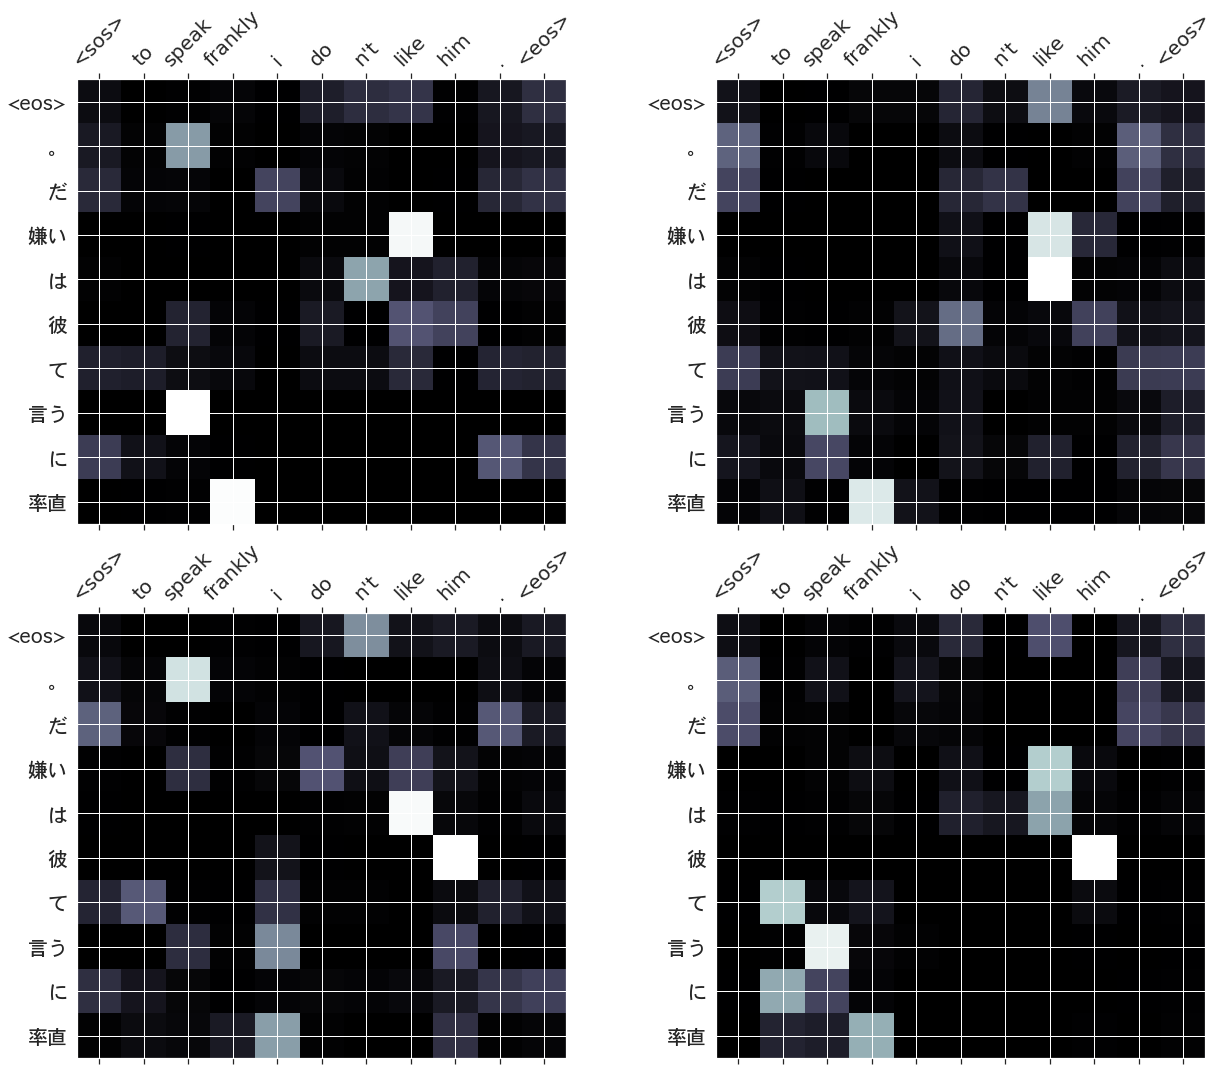

src      : when will he go home ?
trg      : 。 か です の 帰れる に 家 いつ は 彼
predicted: <eos> 。 か ます する 帰宅 つ いる は 彼
     blue: 86.33%


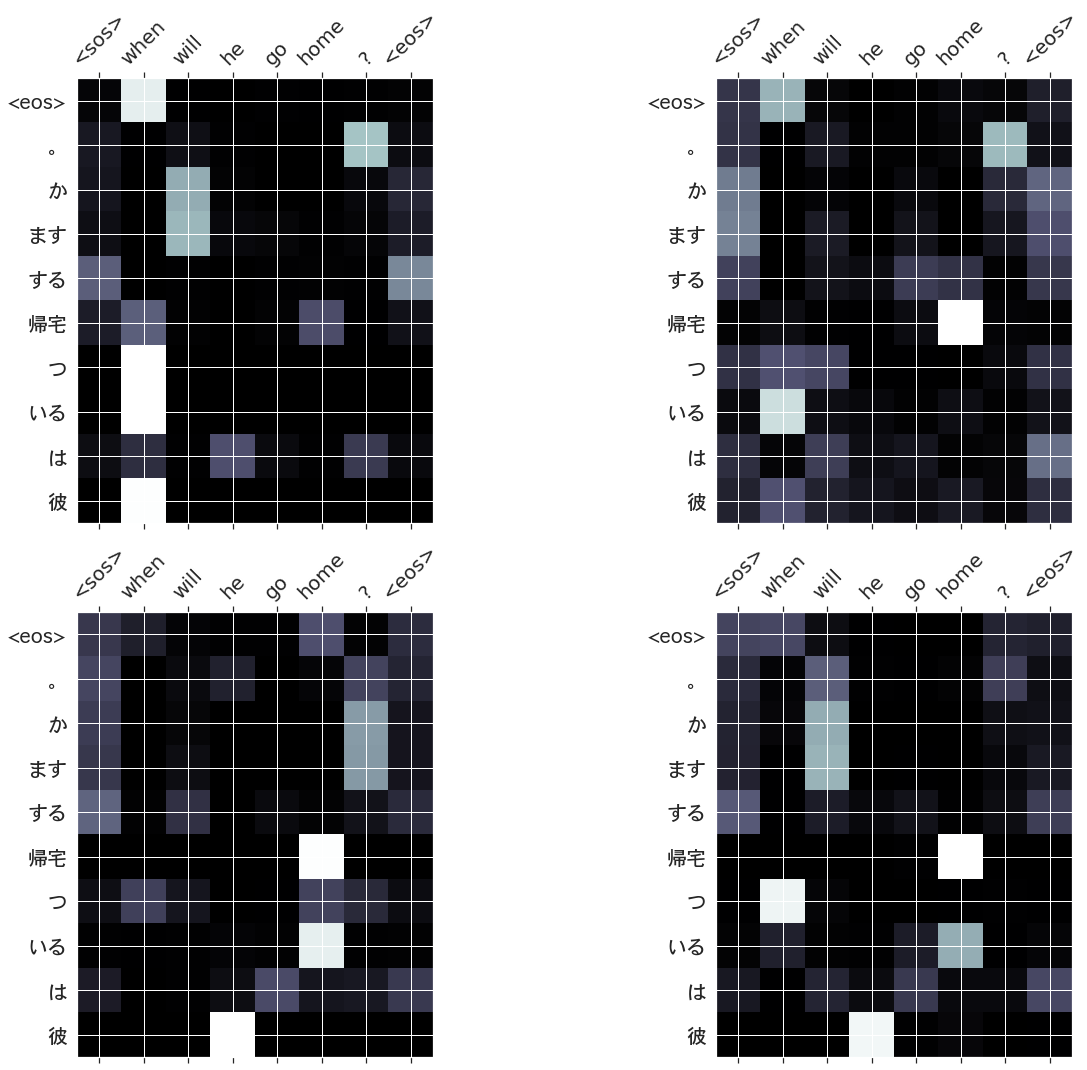

src      : how come you did n't come to the party ?
trg      : 。 か です の た ない 来る に パーティー は あなた 、 どうして
predicted: <eos> 。 か です の た 来る て やる どう は に パーティー
     blue: 87.39%


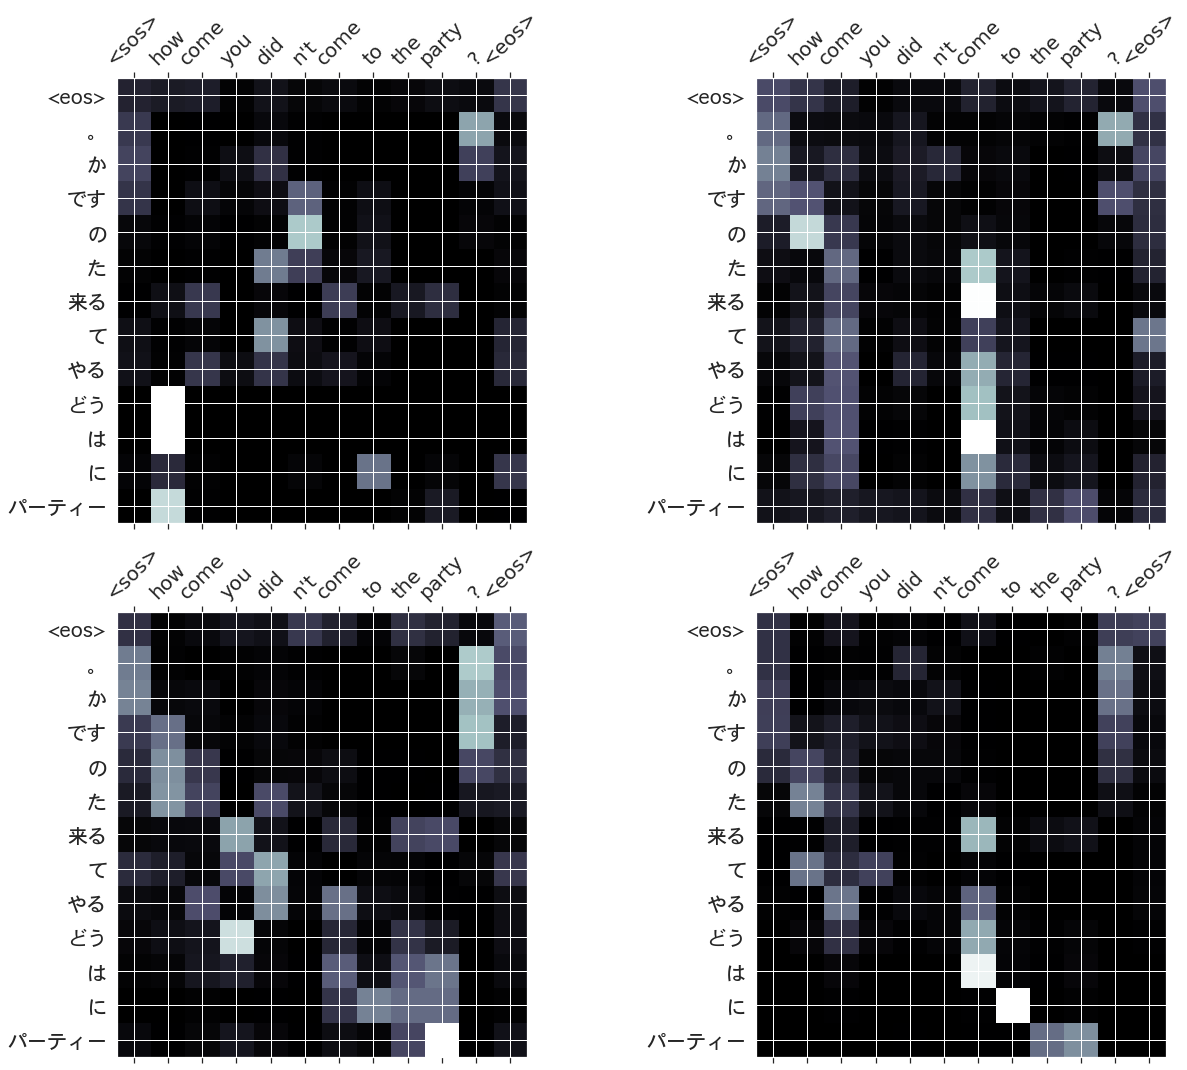

src      : the idea made my soul rise .
trg      : 。 た 高ぶる は 心 の 私 と 思う そう
predicted: <eos> 。 た 引き起こす を 心 の 私 は 考え その
     blue: 88.01%


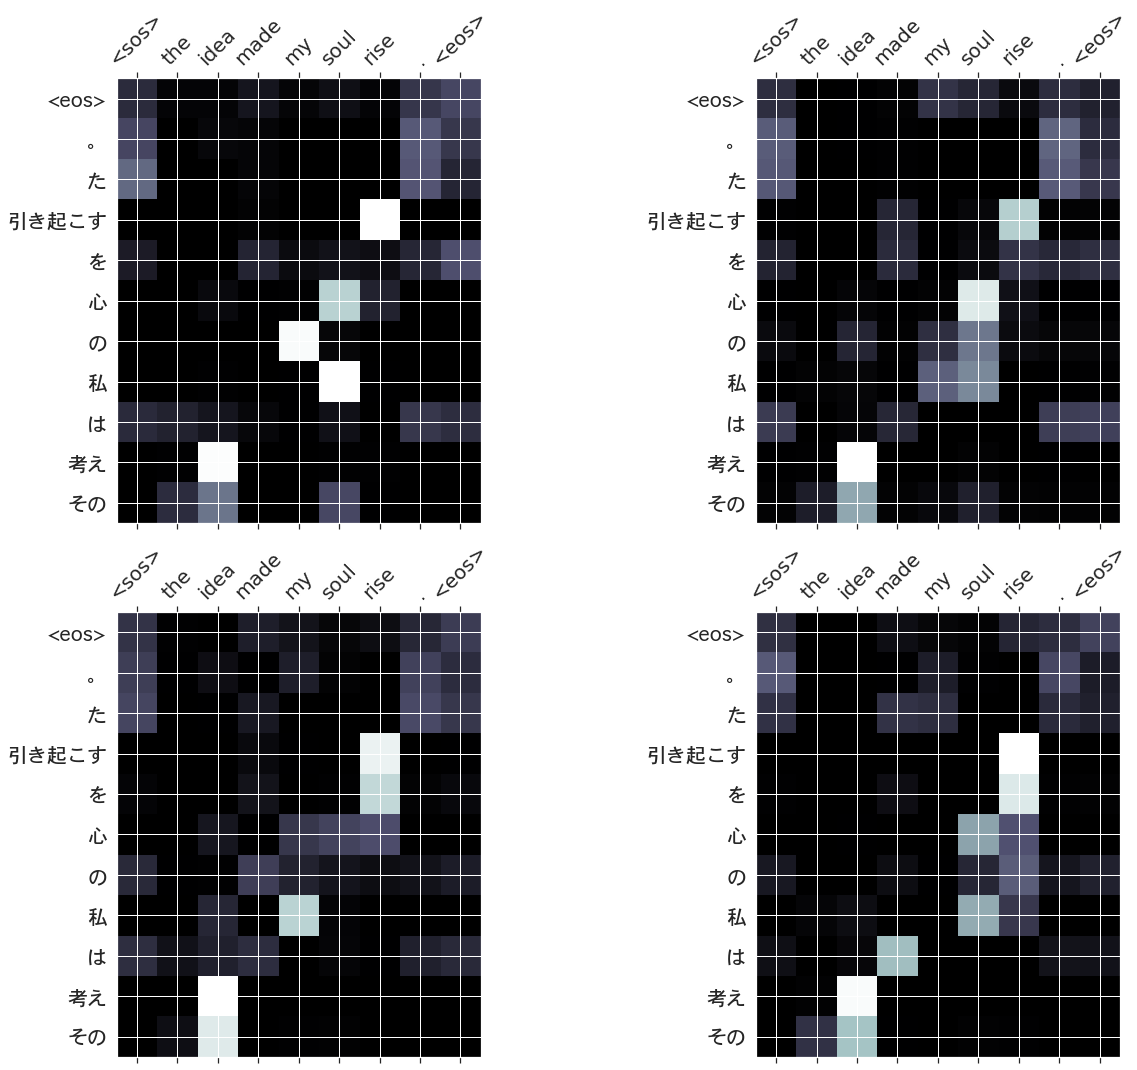

src      : he went up the steps slowly .
trg      : 。 た 上る と ゆっくり を 階段 は 彼
predicted: <eos> 。 た 上がる と ゆっくり を 階段 は 彼
     blue: 90.36%


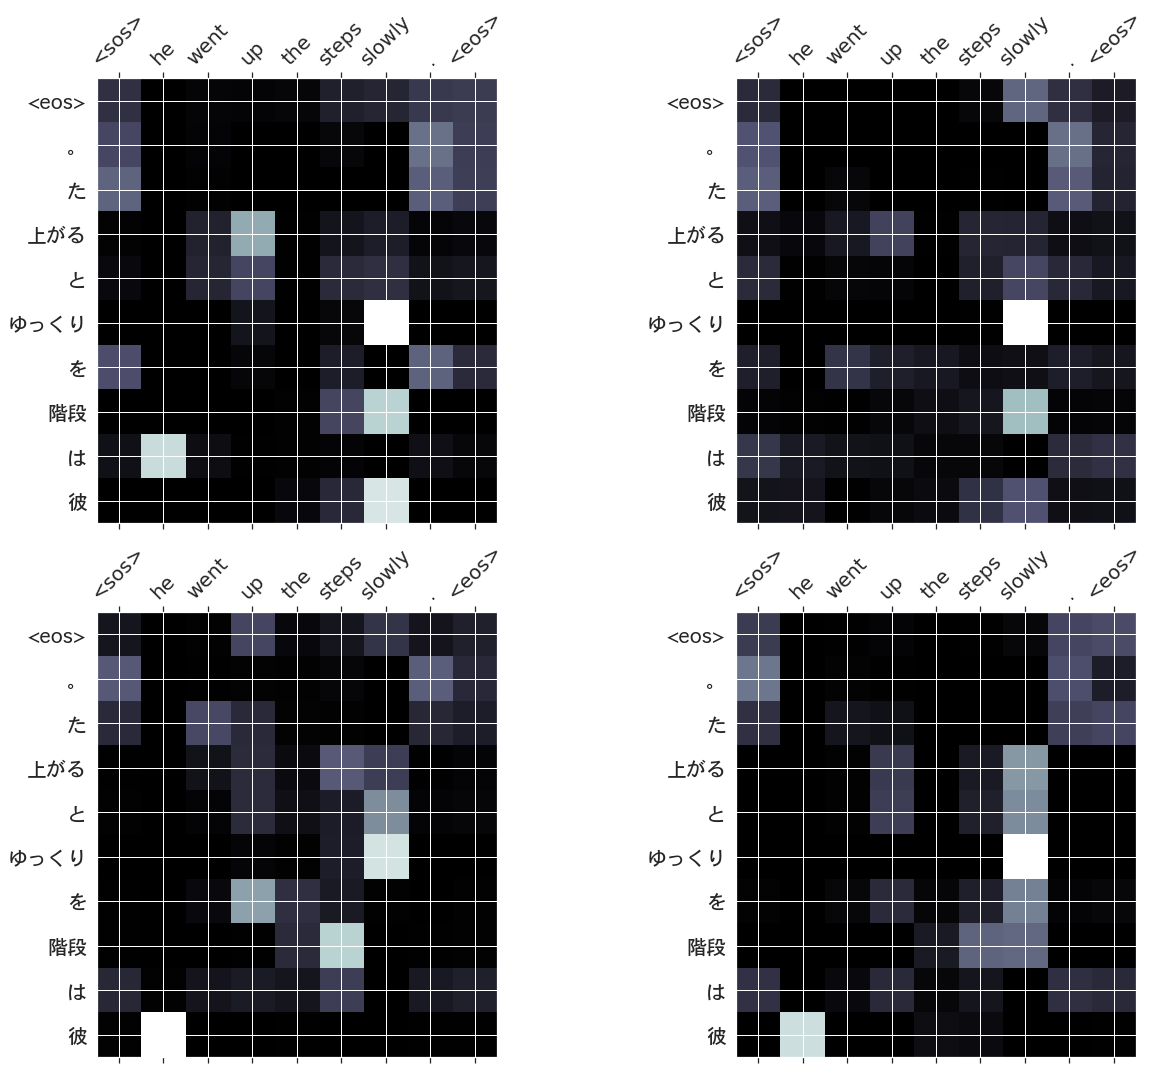

src      : a crowd gathered around .
trg      : 。 た 集まる に 周り が 群集
predicted: <eos> 。 た 集まる に 周り が 群衆
     blue: 86.94%


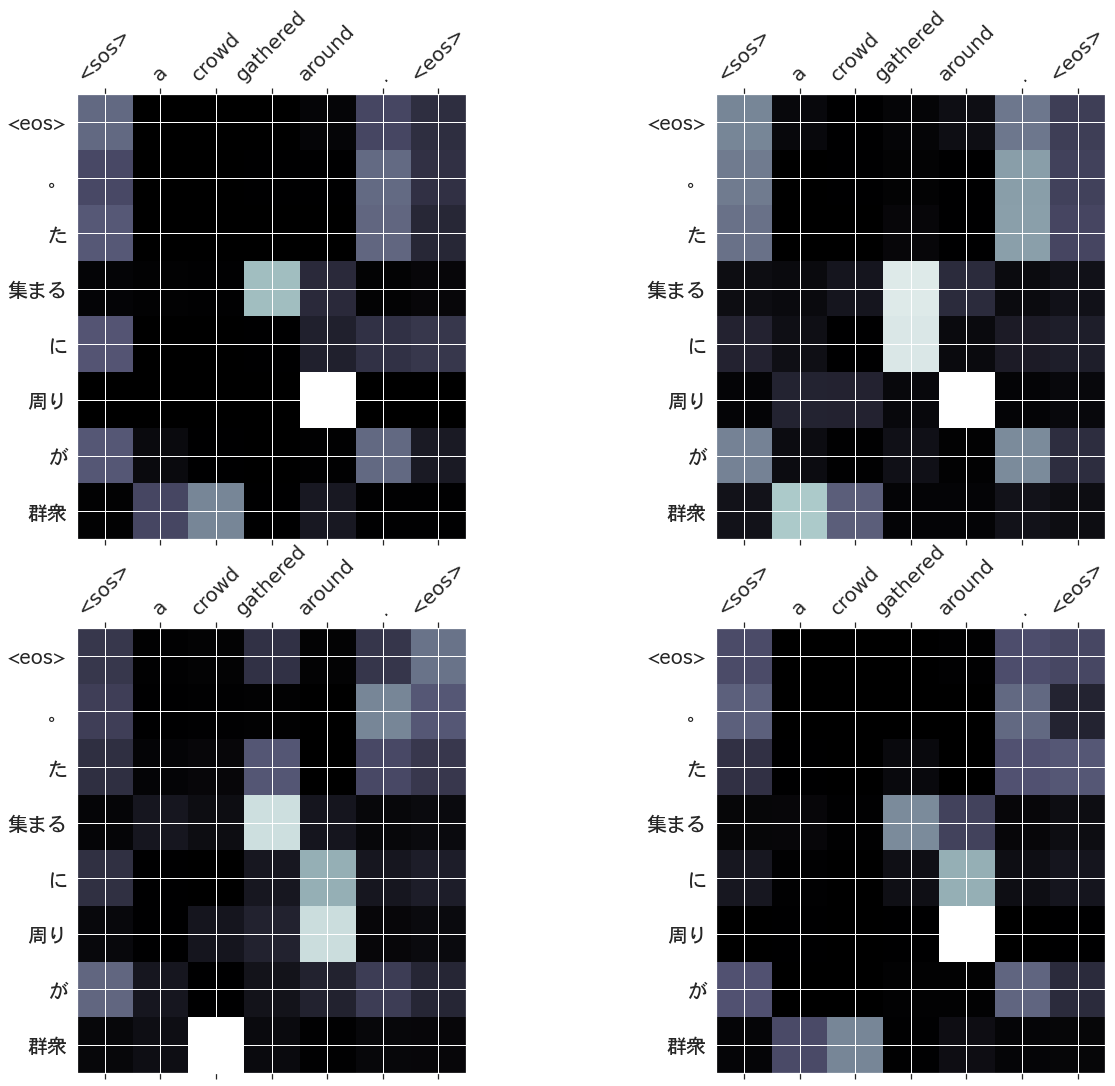

src      : we happened to be in hokkaido then .
trg      : 。 た いる に 北海道 たまたま とき その は 達 私
predicted: <eos> 。 た いる に 北海道 たまたま は たち 私
     blue: 86.33%


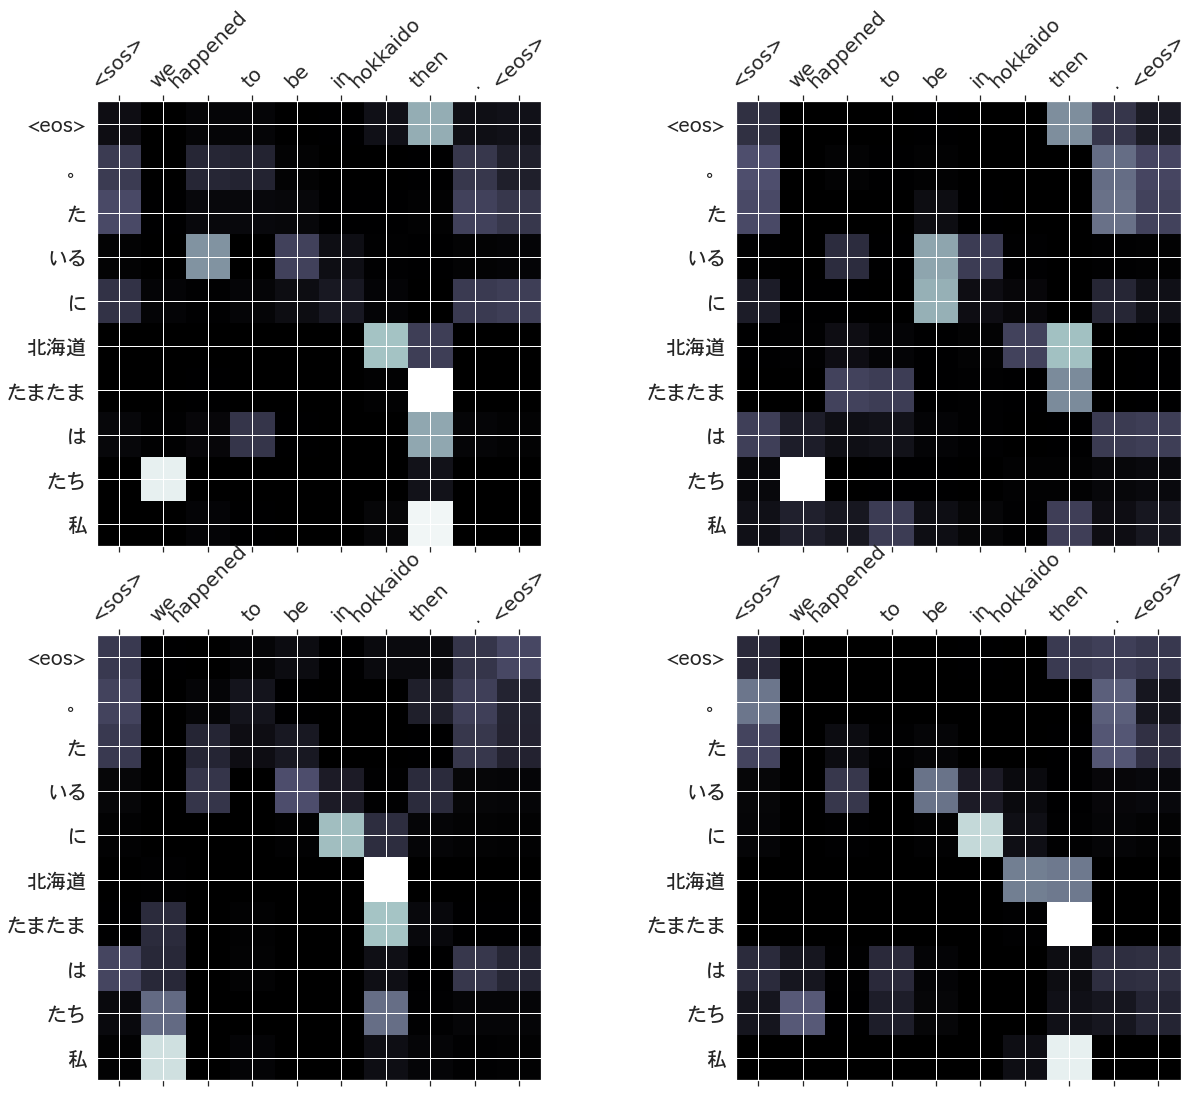

src      : the chimney is belching black smoke .
trg      : 。 いる て する 噴出 を 煙 真っ黒い は 煙突 その
predicted: <eos> 。 いる て する <unk> を 煙 は 煙突
     blue: 86.33%


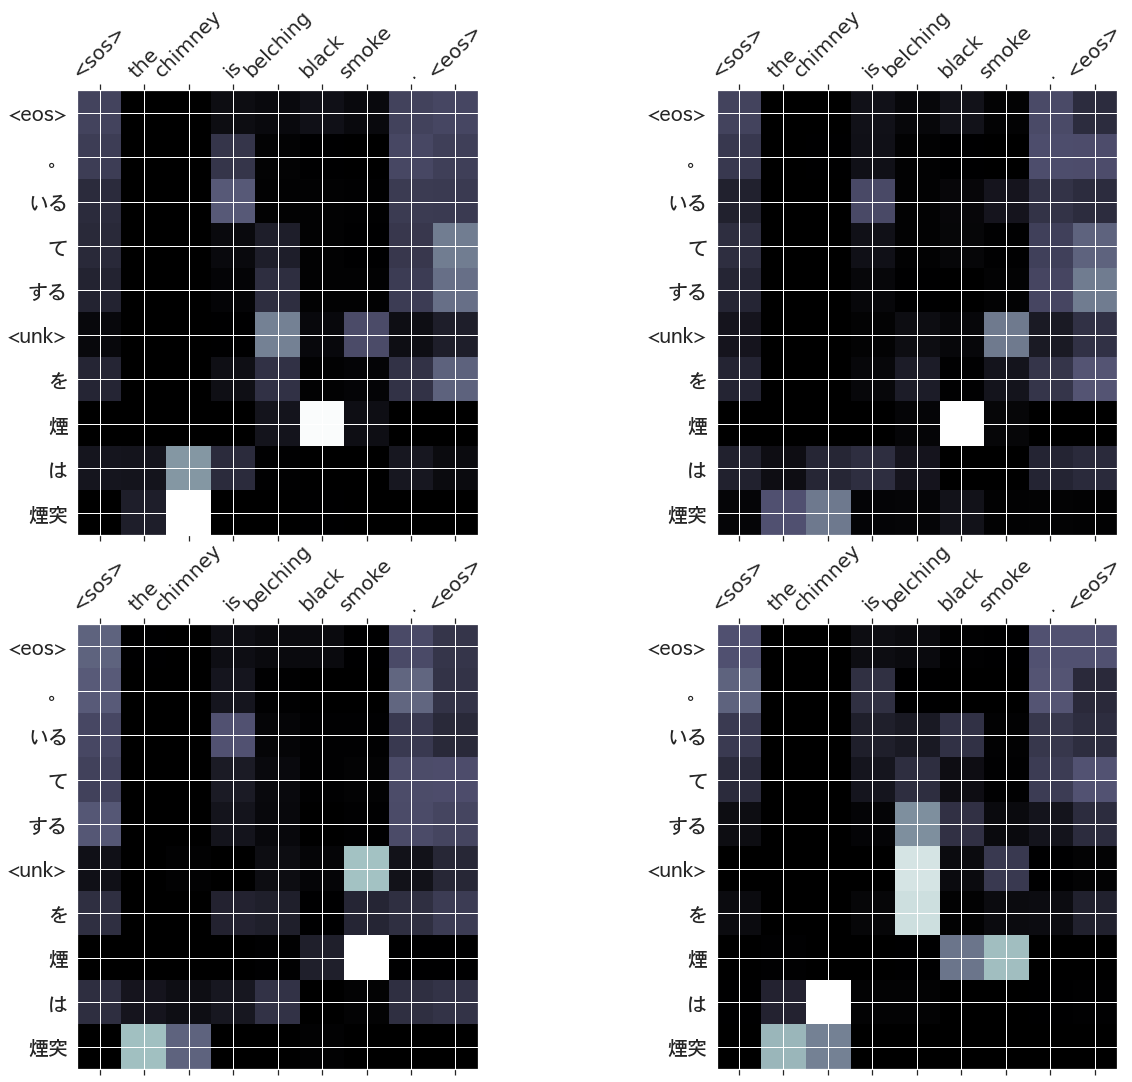

src      : what is the departure time ?
trg      : 。 か です 時 何 は 時刻 出発
predicted: <eos> 。 か です 時 何 は 出発
     blue: 91.93%


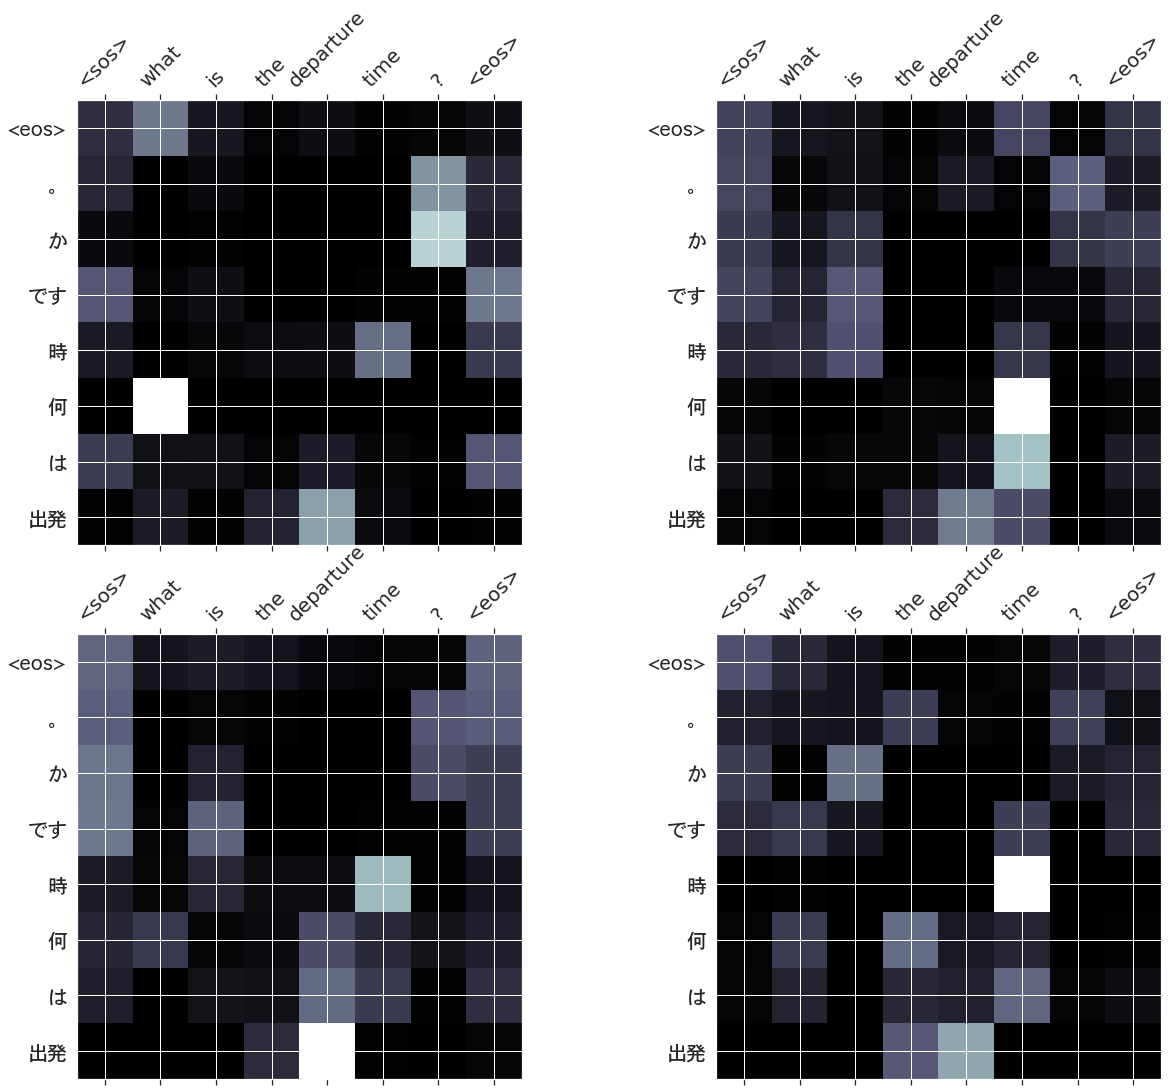

src      : we played all together .
trg      : 。 だ 遊ぶ に いっしょ みんな は たち 私
predicted: <eos> 。 だ 遊ぶ に 一緒 みんな は たち 私
     blue: 86.33%


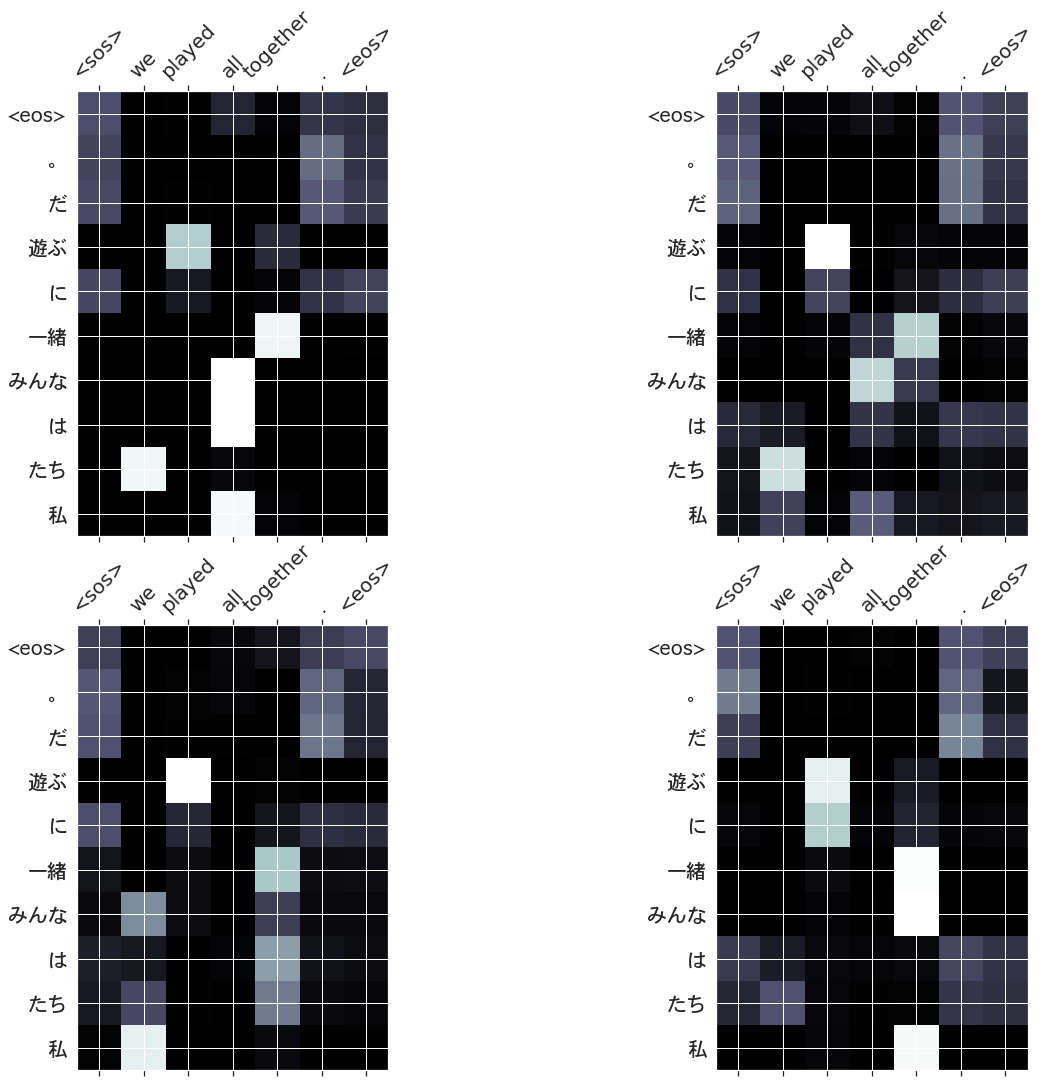

src      : mr white 's yard is large .
trg      : 。 広い は 庭 の うち の さん ホワイト
predicted: <eos> 。 広い は 庭 の 氏 ホワイト
     blue: 86.94%


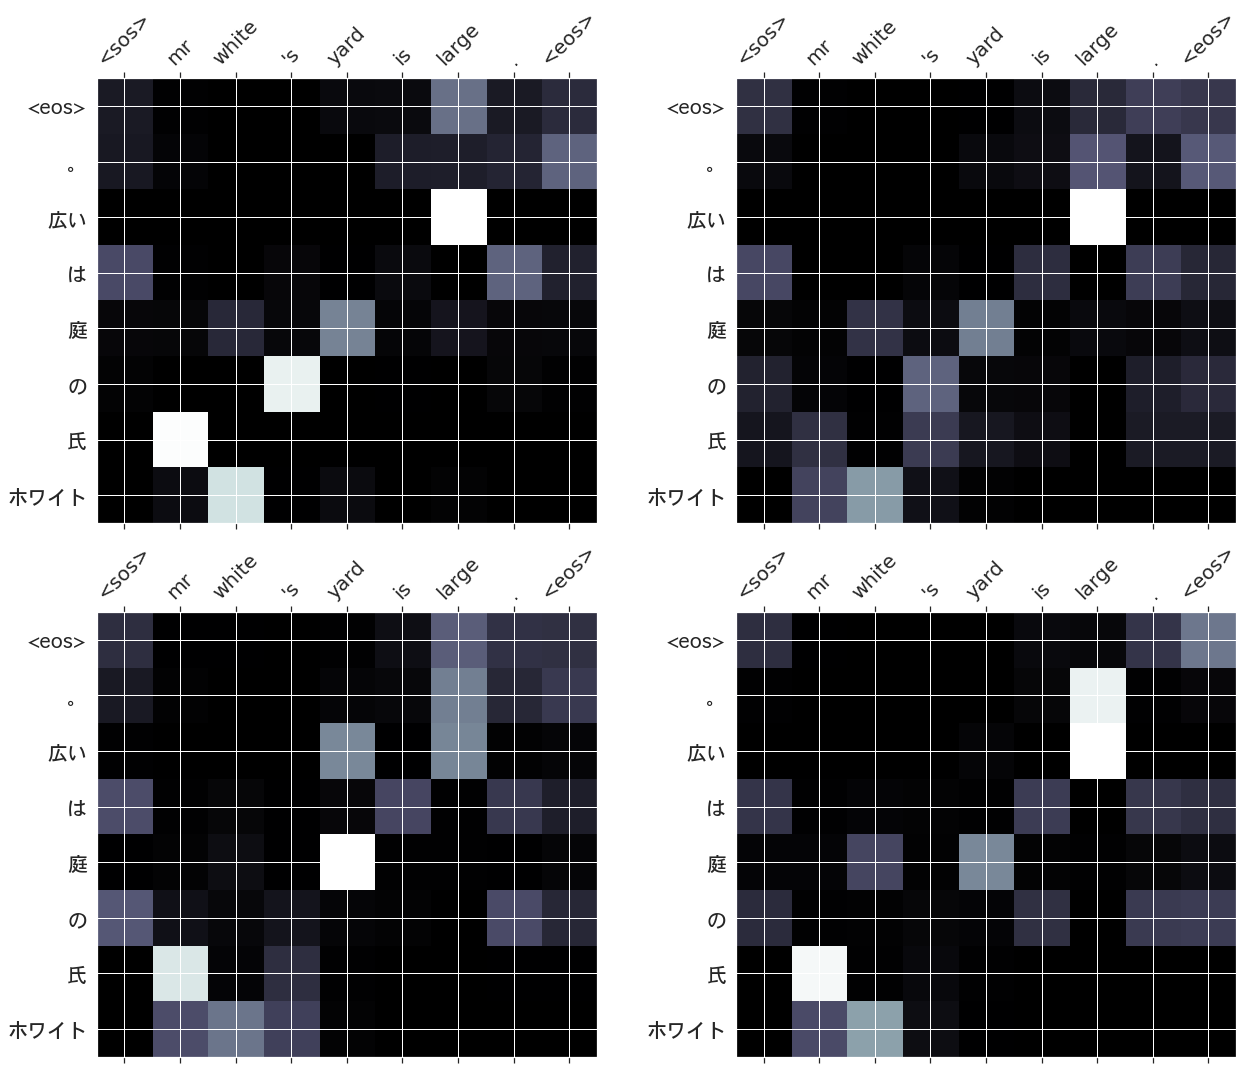

src      : will you open the window , please ?
trg      : 。 か ん ます くれる て あける を 窓 、 が すみません
predicted: <eos> 。 か ん ます くれる て 開ける を 窓
     blue: 90.36%


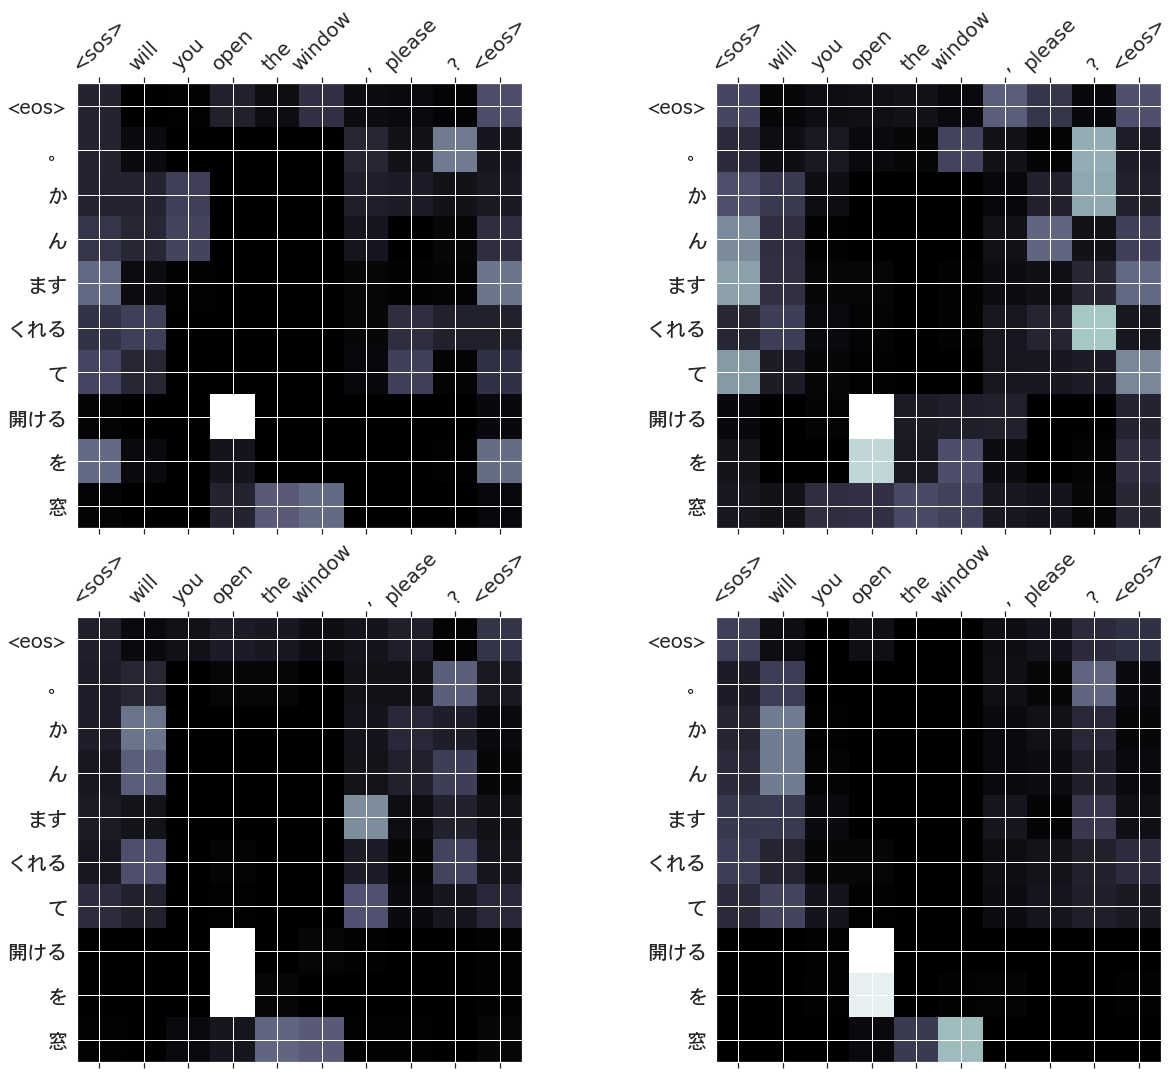

src      : at midnight , we reached the village by car .
trg      : 。 た する 到着 で 車 に 村 その は われわれ に 真夜中
predicted: <eos> 。 た 着く に 村 その で 車 まで 真夜中 は たち 私
     blue: 85.66%


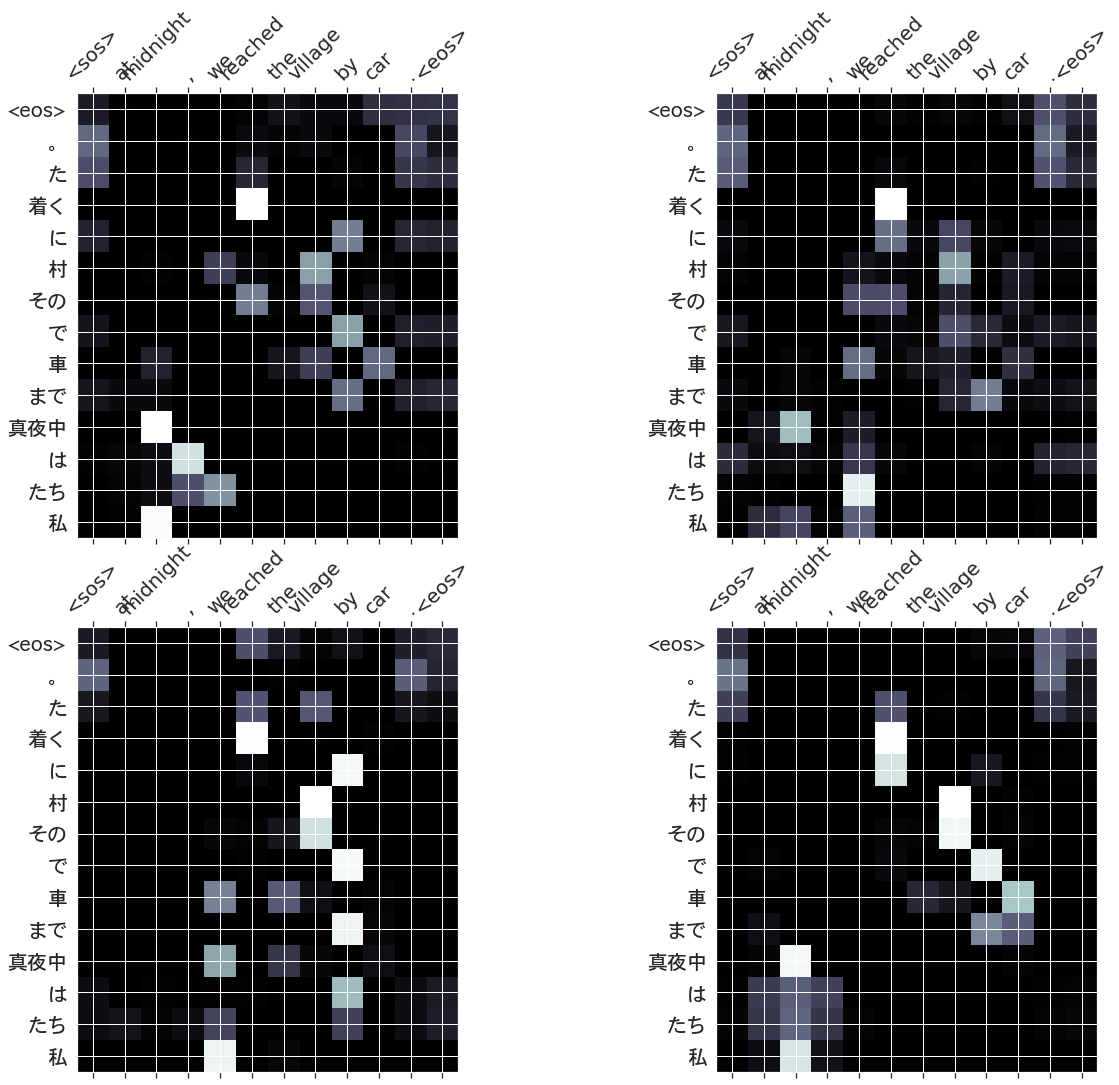

src      : please wake me up at six tomorrow morning .
trg      : 。 くださる て 起こす に 時 6 朝 の 明日
predicted: <eos> 。 くださる て 起こす に 時 ６ 朝 の 明日
     blue: 88.01%


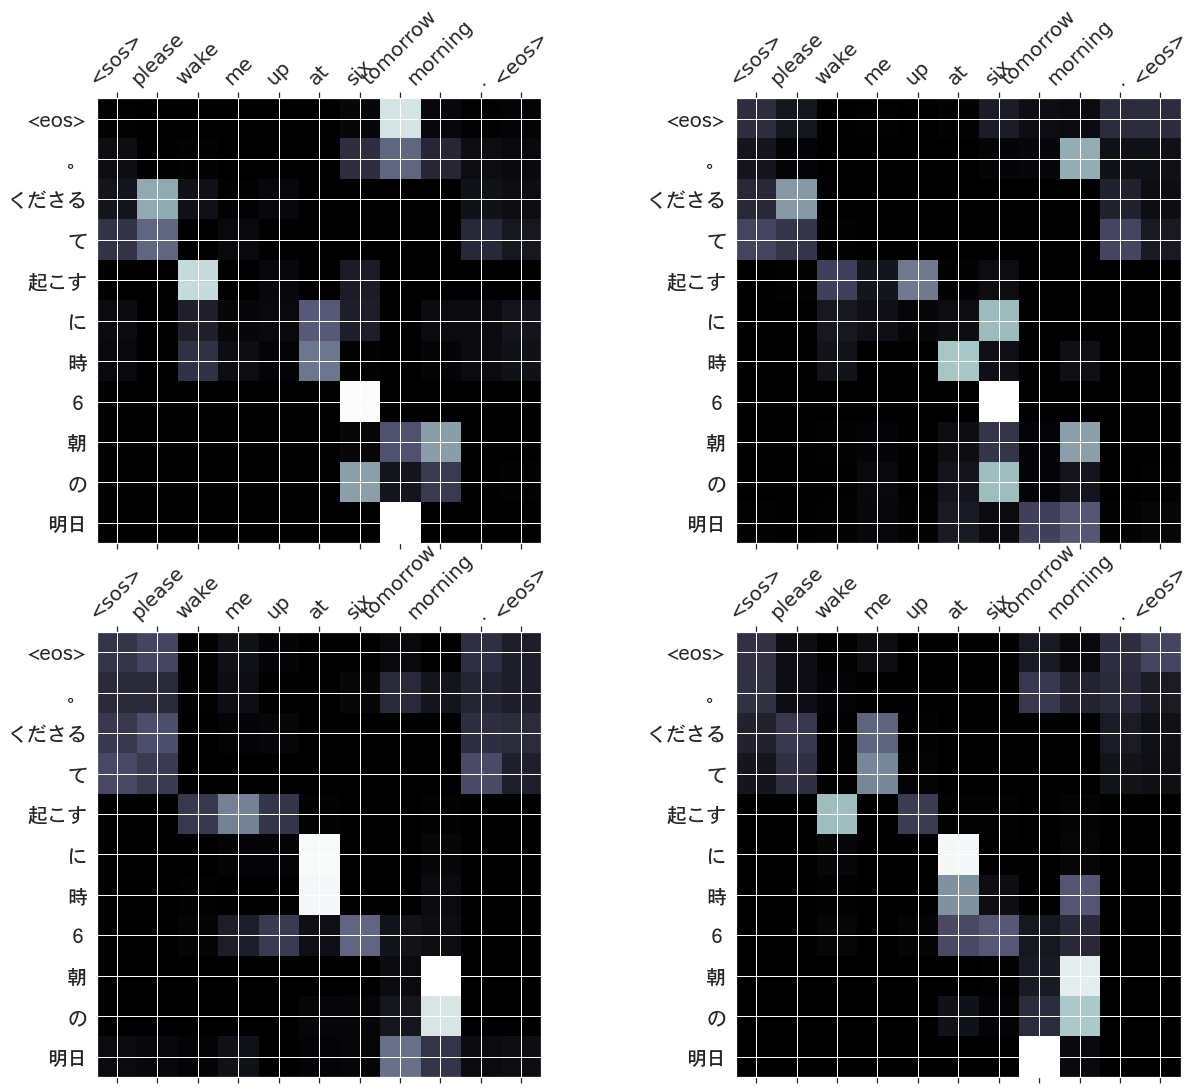

src      : we have had plenty of rain this year .
trg      : 。 た 多い が 雨 は 今年
predicted: <eos> 。 た 降る たくさん が 雨 は 今年
     blue: 88.91%


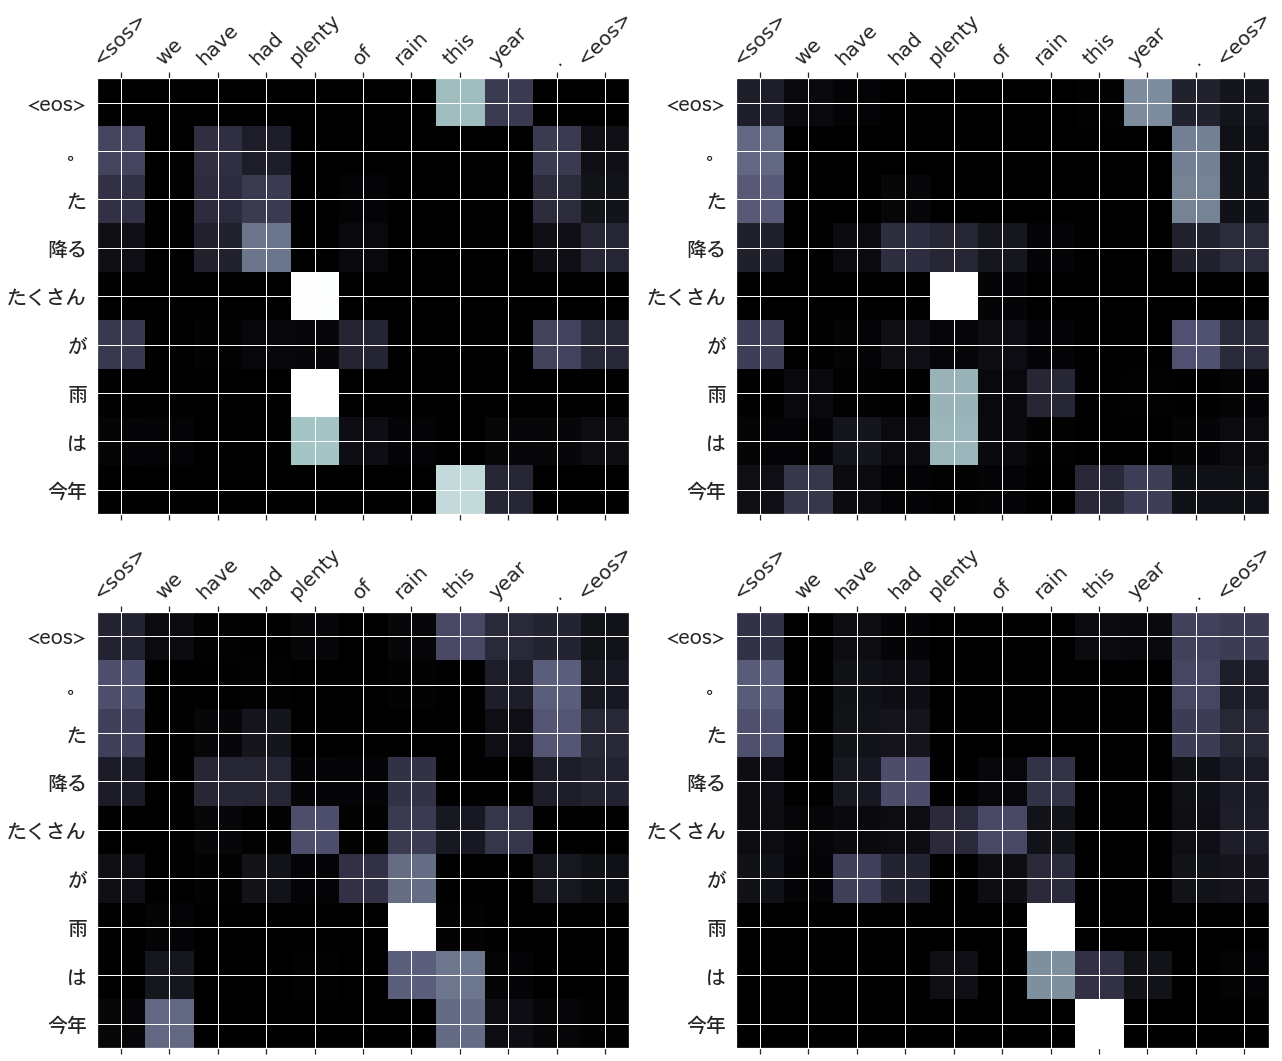

src      : stick the bag down under the seat .
trg      : 。 くださる て 置く に 下 の 座席 を 鞄
predicted: <eos> 。 くださる て 置く を かばん に 下 の 座席
     blue: 88.01%


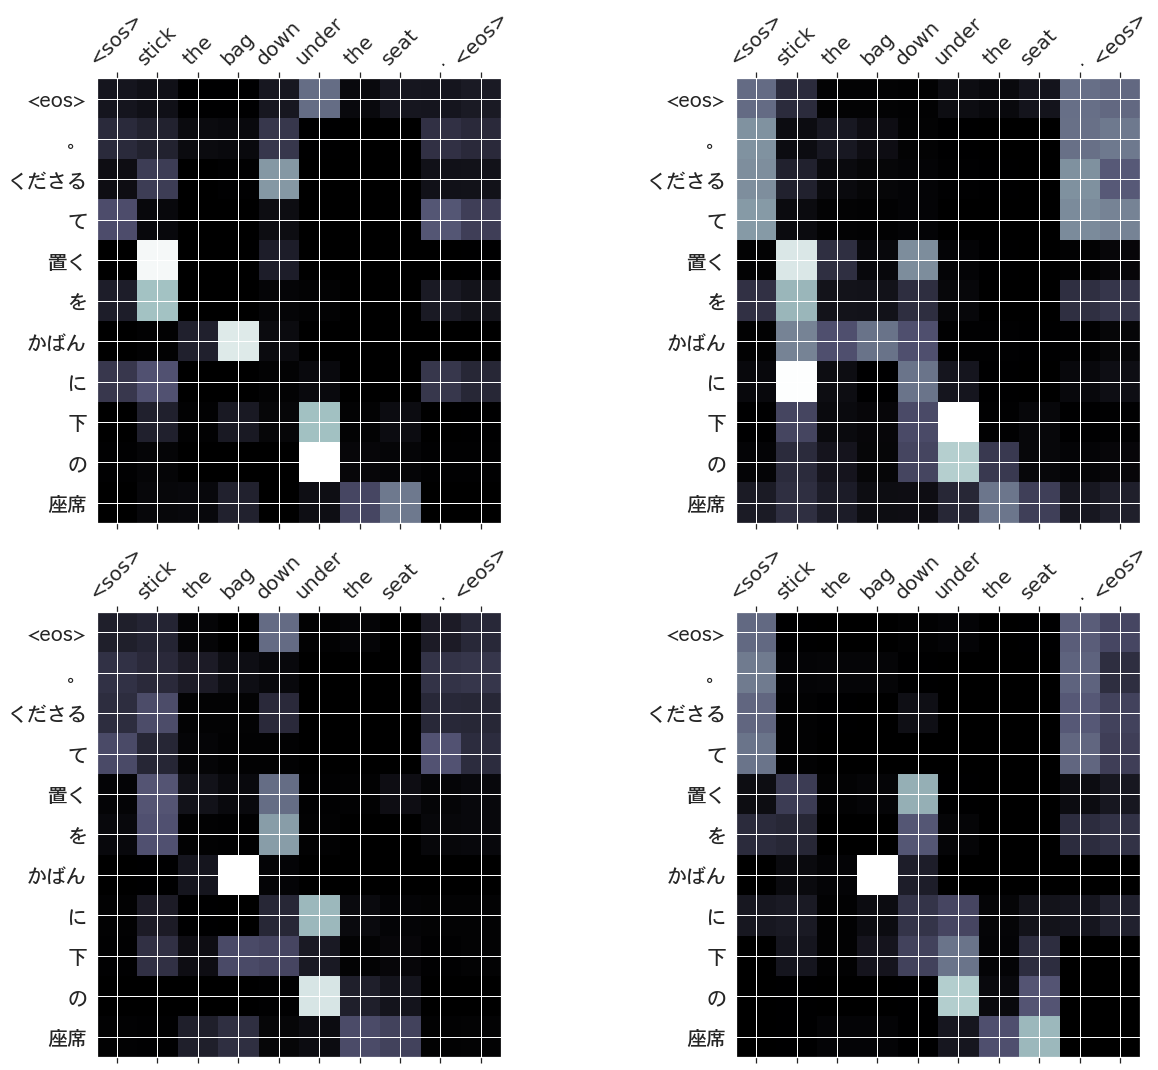

src      : the truth will clear soon .
trg      : 。 う だ なる に 明らか 間もなく は 真相
predicted: <eos> 。 う だ なる に 明らか まもなく は 真実
     blue: 86.33%


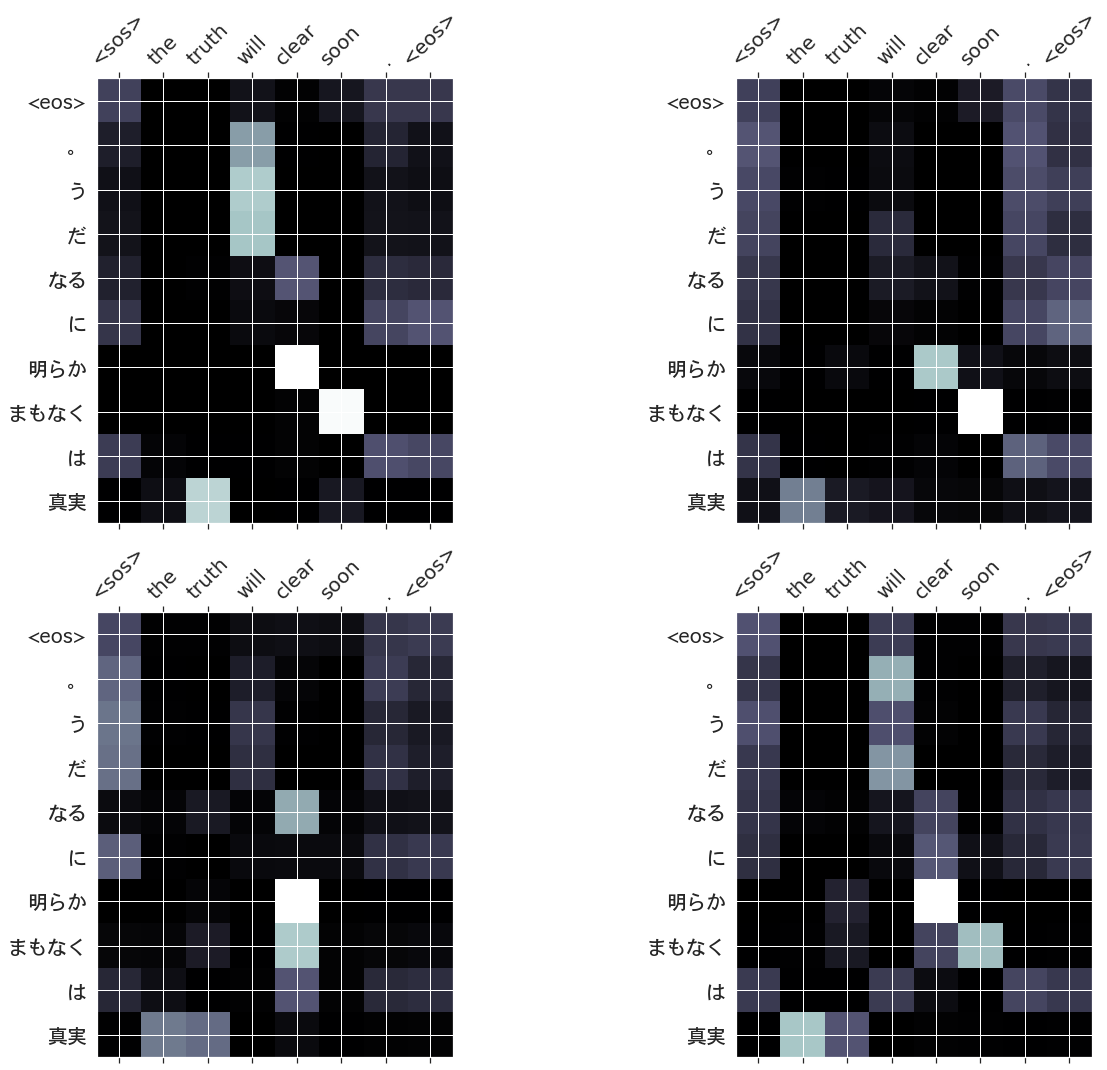

src      : he lives up there , up on that mountain .
trg      : 。 ます いる で 住む に 山の上 あの 、 上 の 向こう は 彼
predicted: <eos> 。 いる て 起きる で 山 その は 彼
     blue: 86.33%


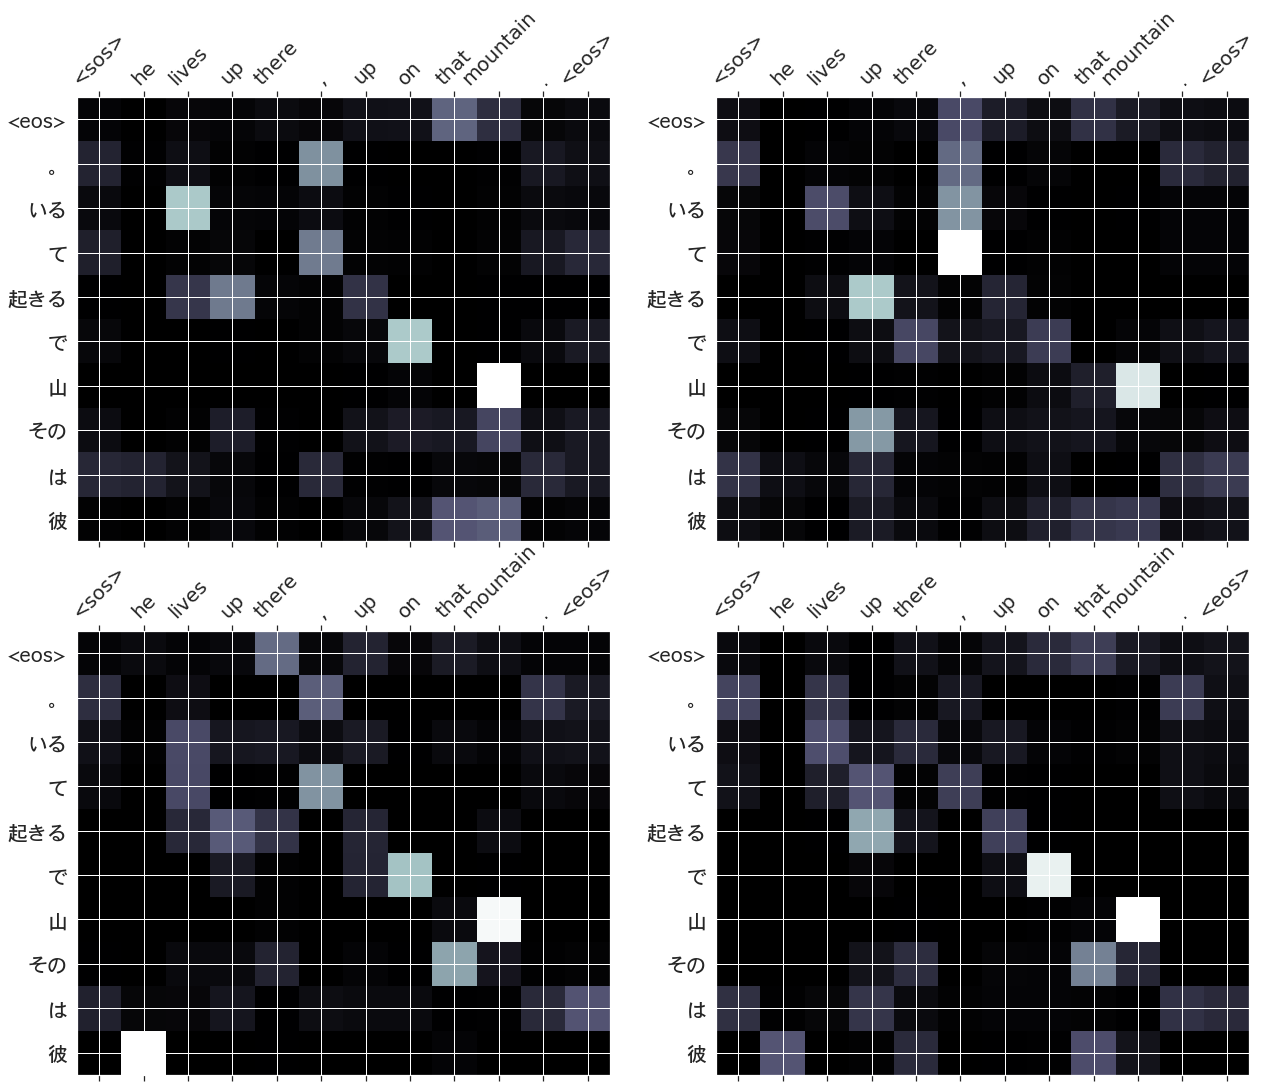

src      : there is a television in my room .
trg      : 。 ある が テレビ は に 部屋 の 私
predicted: <eos> 。 ある が テレビ は に 部屋 の 私
     blue: 90.36%


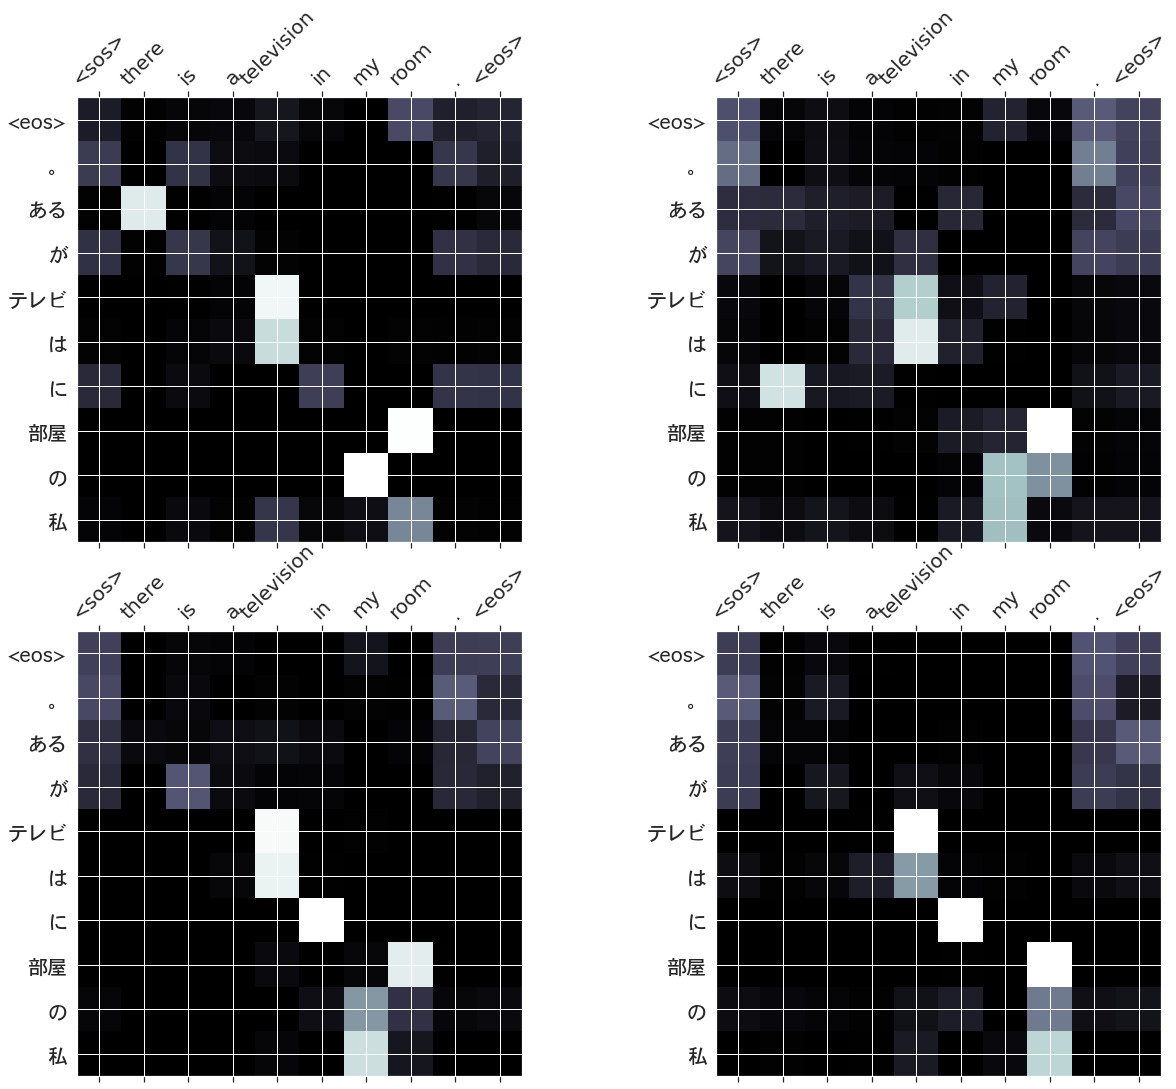

src      : he is playing outdoors .
trg      : 。 ます いる で 遊ぶ で 外 は 彼
predicted: <eos> 。 いる で 遊ぶ で 外 は 彼
     blue: 88.91%


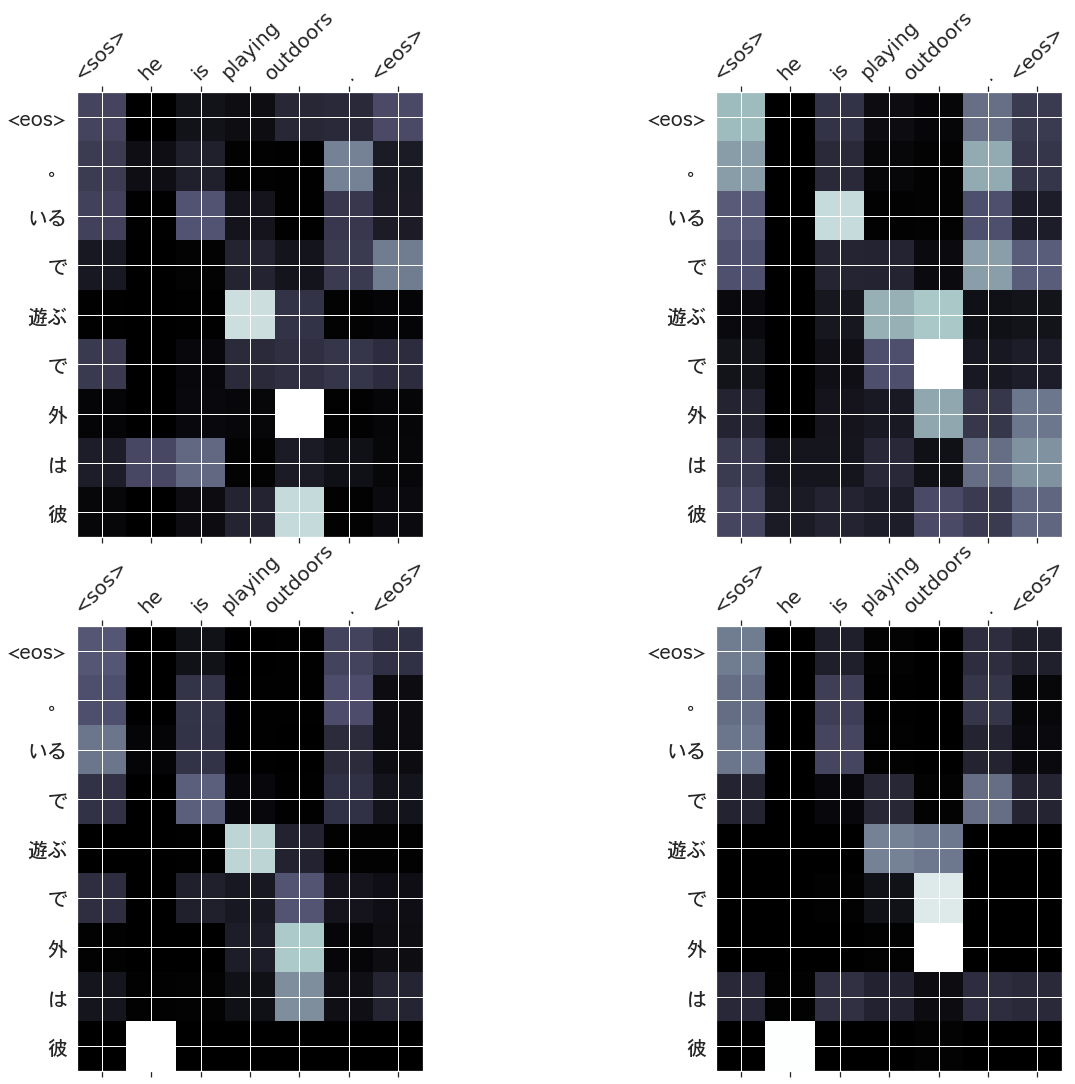

src      : she sleeps with two pillows .
trg      : 。 いる て 使う 二つ を 枕 は 彼女
predicted: <eos> 。 使う ２つ を 枕 は 彼女
     blue: 86.94%


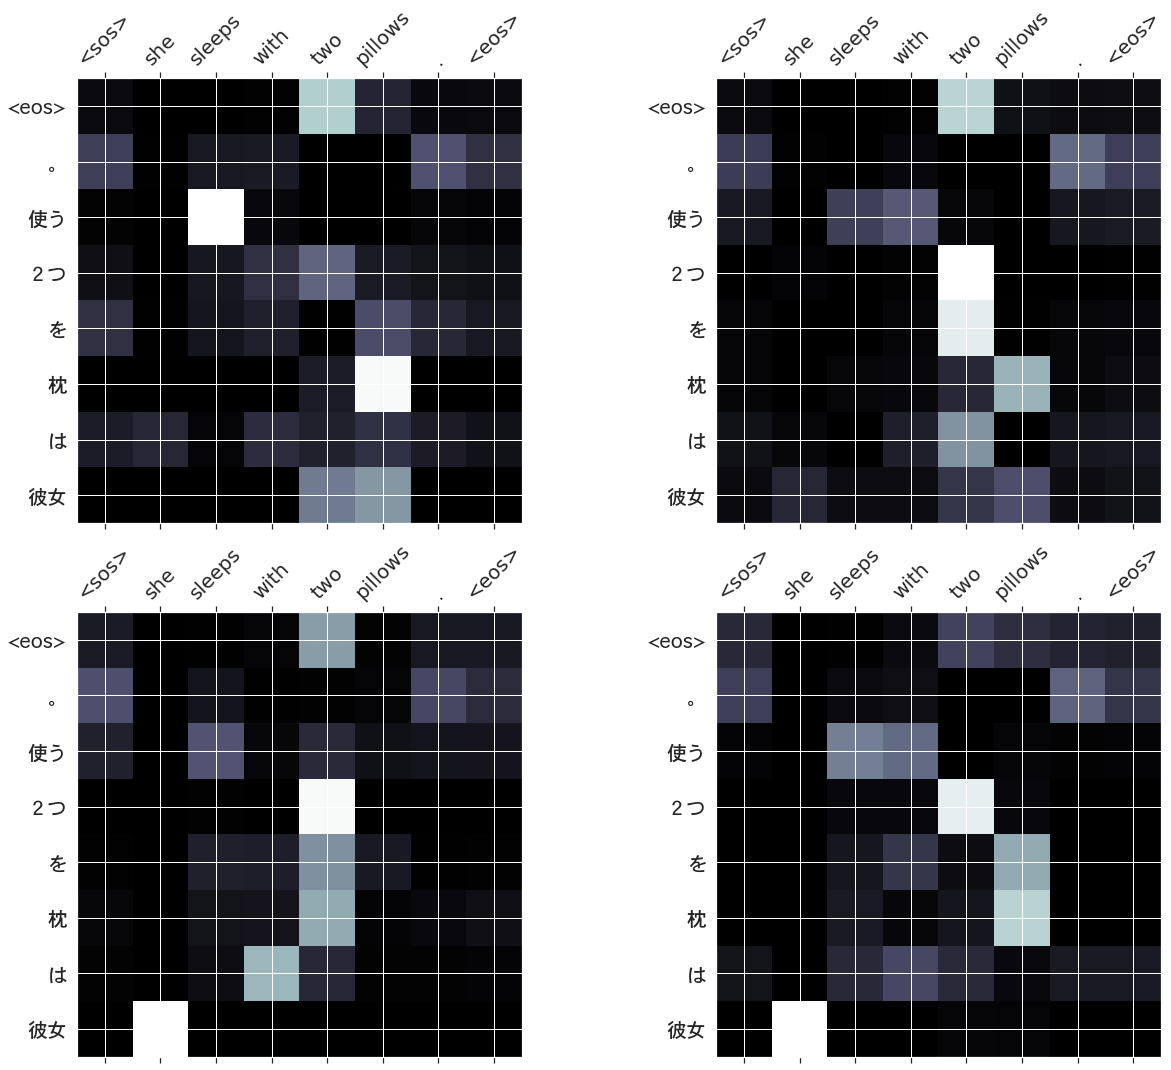

src      : i fed some meat to my dog .
trg      : 。 た 与える を 肉 に 犬 は 私
predicted: <eos> 。 た やる 少し を 肉 に 犬 は 私
     blue: 94.57%


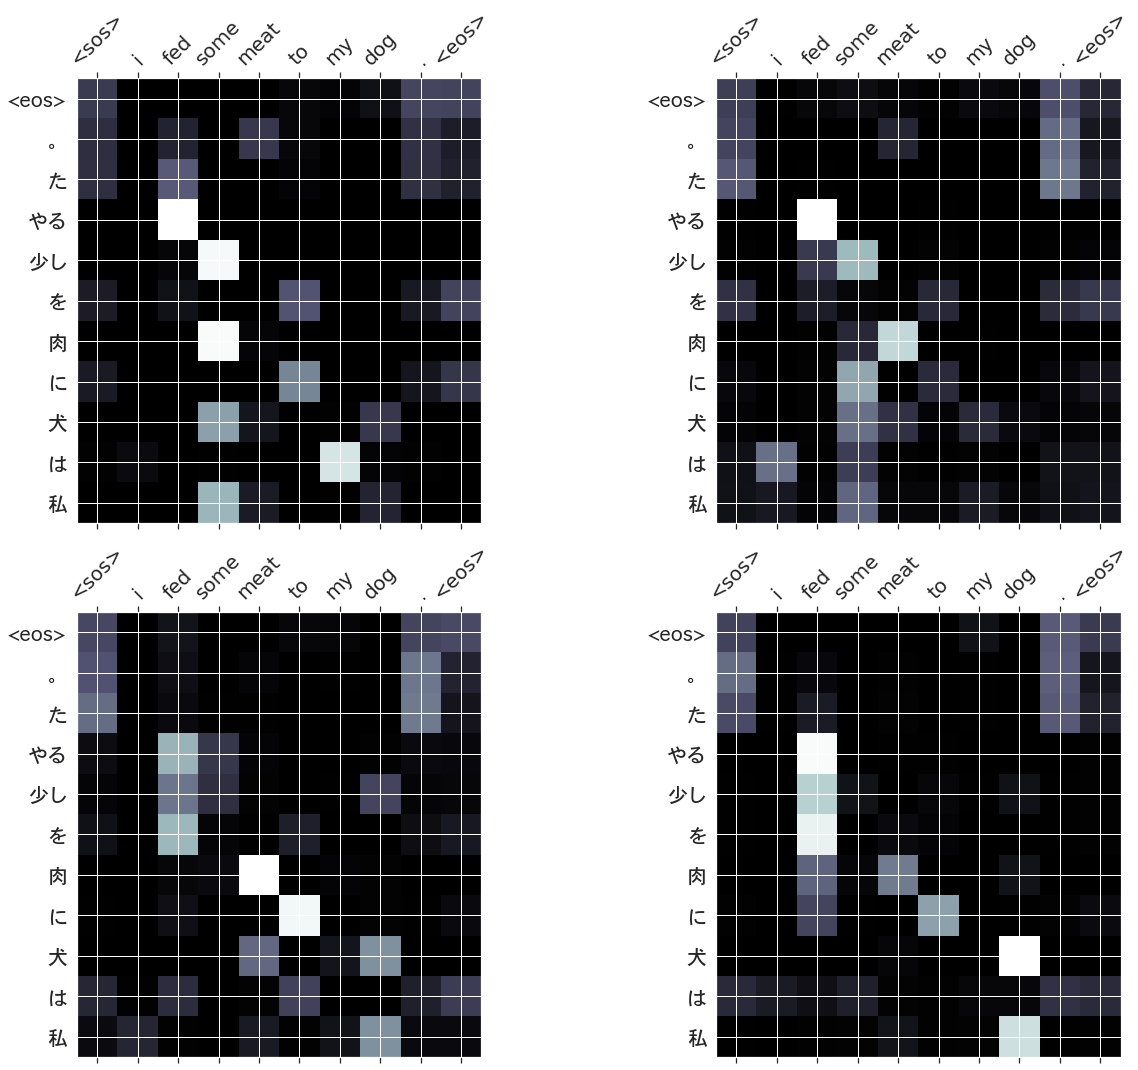

src      : i studied for a while this morning .
trg      : 。 た する 勉強 間 の しばらく 午前 の きょう は 私
predicted: <eos> 。 た する 勉強 間 の しばらく 今朝 は 私
     blue: 88.01%


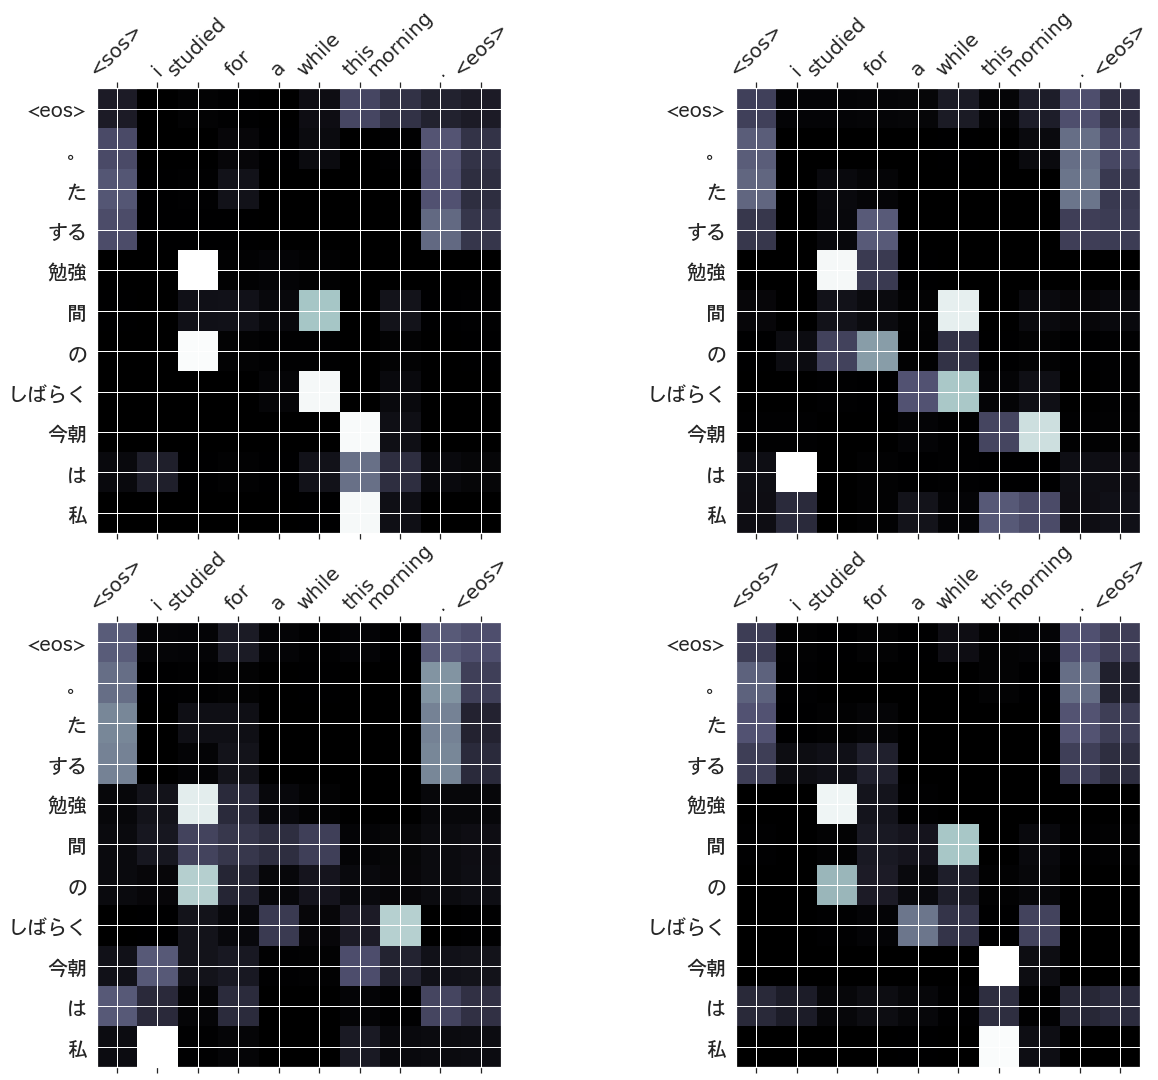

src      : he has an eye for people .
trg      : 。 ある が 目 見る を 人 は 彼
predicted: <eos> 。 ある が 眼 せる する いらいら を 人 は 彼
     blue: 85.94%


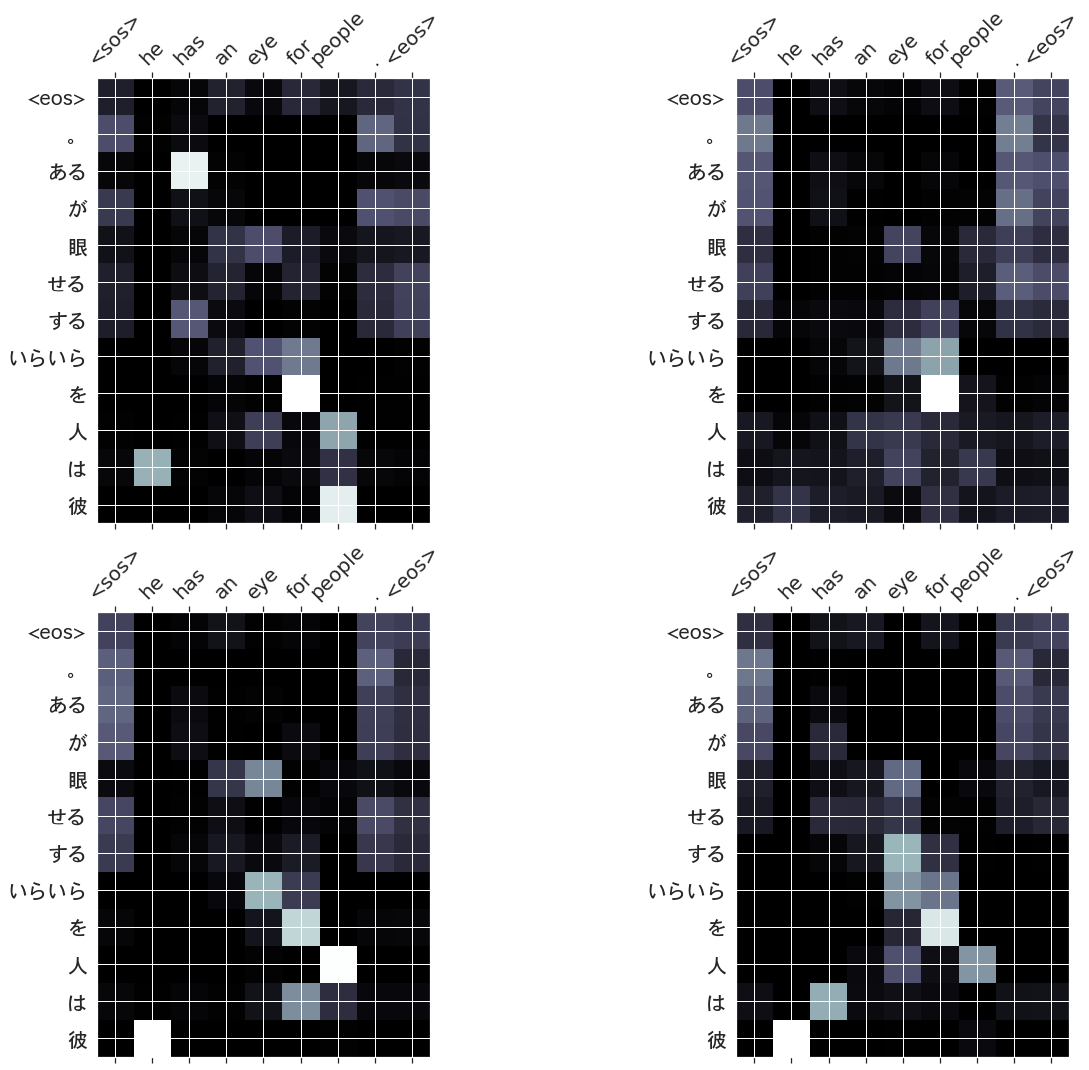

src      : the hardness of diamond is 10 .
trg      : 。 ある だ ０ １ は 硬度 の ダイヤモンド
predicted: <eos> 。 です 分 ０ １ は <unk> の ダイヤモンド
     blue: 86.33%


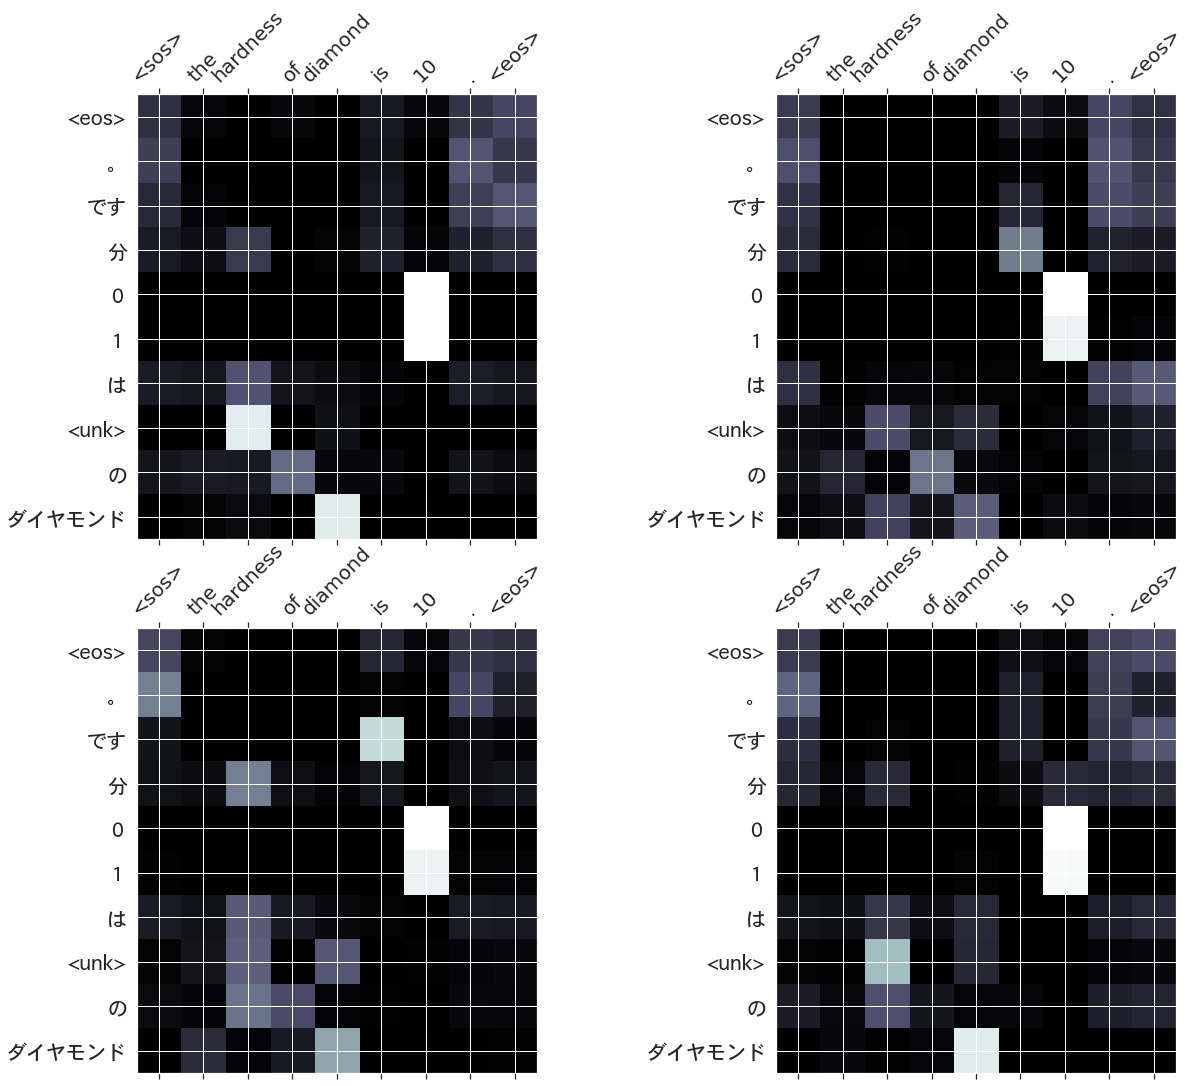

src      : we have had plenty of rain this year .
trg      : 。 た 多い が 雨 は 今年
predicted: <eos> 。 た 降る たくさん が 雨 は 今年
     blue: 88.91%


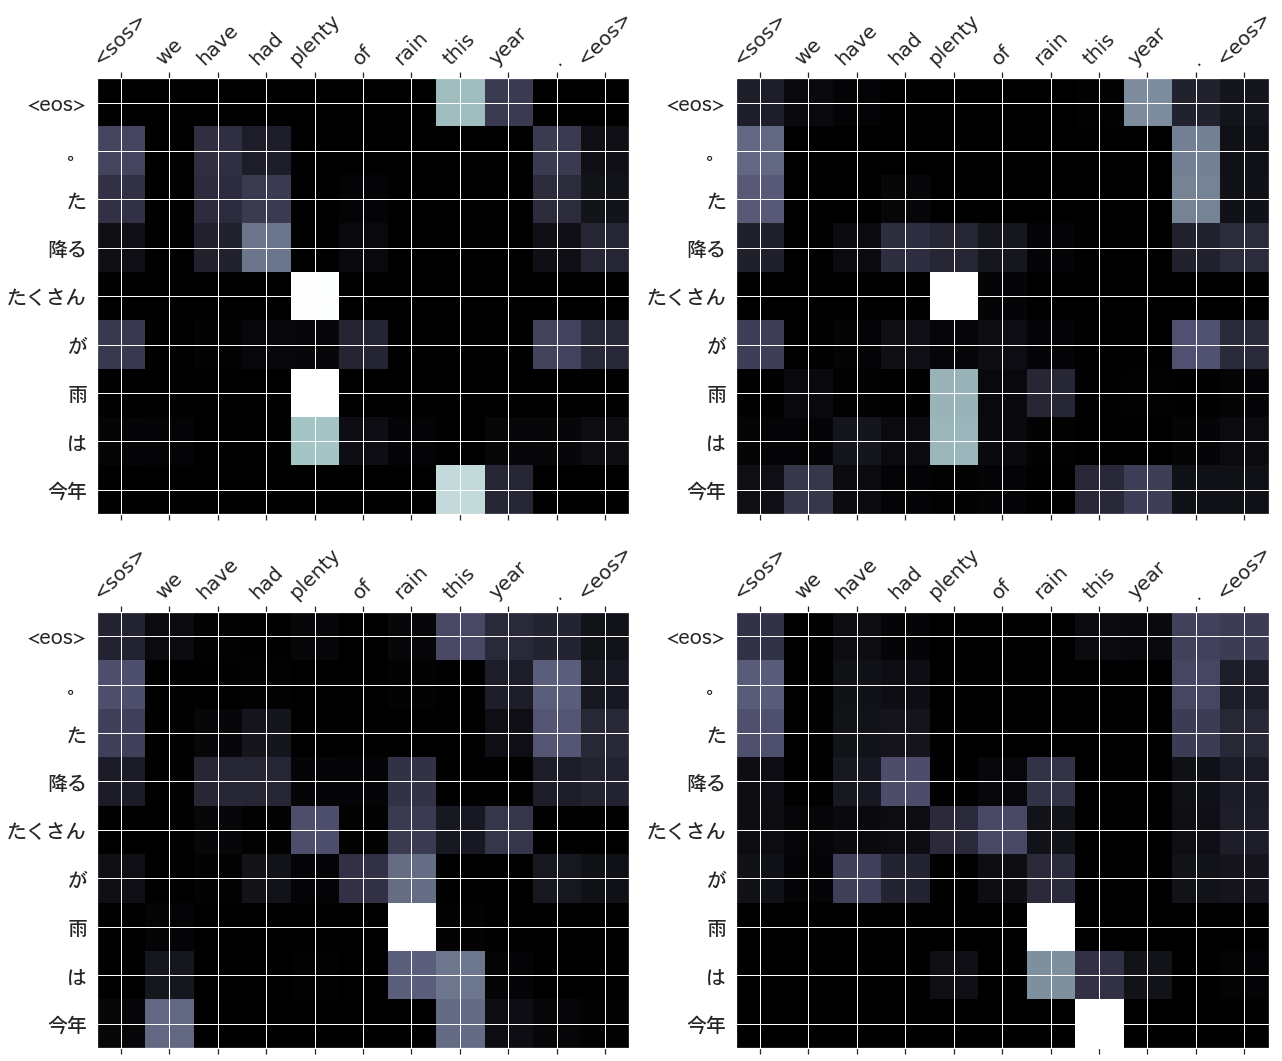

src      : the plane climbed to an altitude of 10,000 meters .
trg      : 。 た 達す に メートル 万 一 高度 は 飛行機 その
predicted: <eos> 。 た 登る に 高度 の メートル 万 １ は 飛行機
     blue: 85.94%


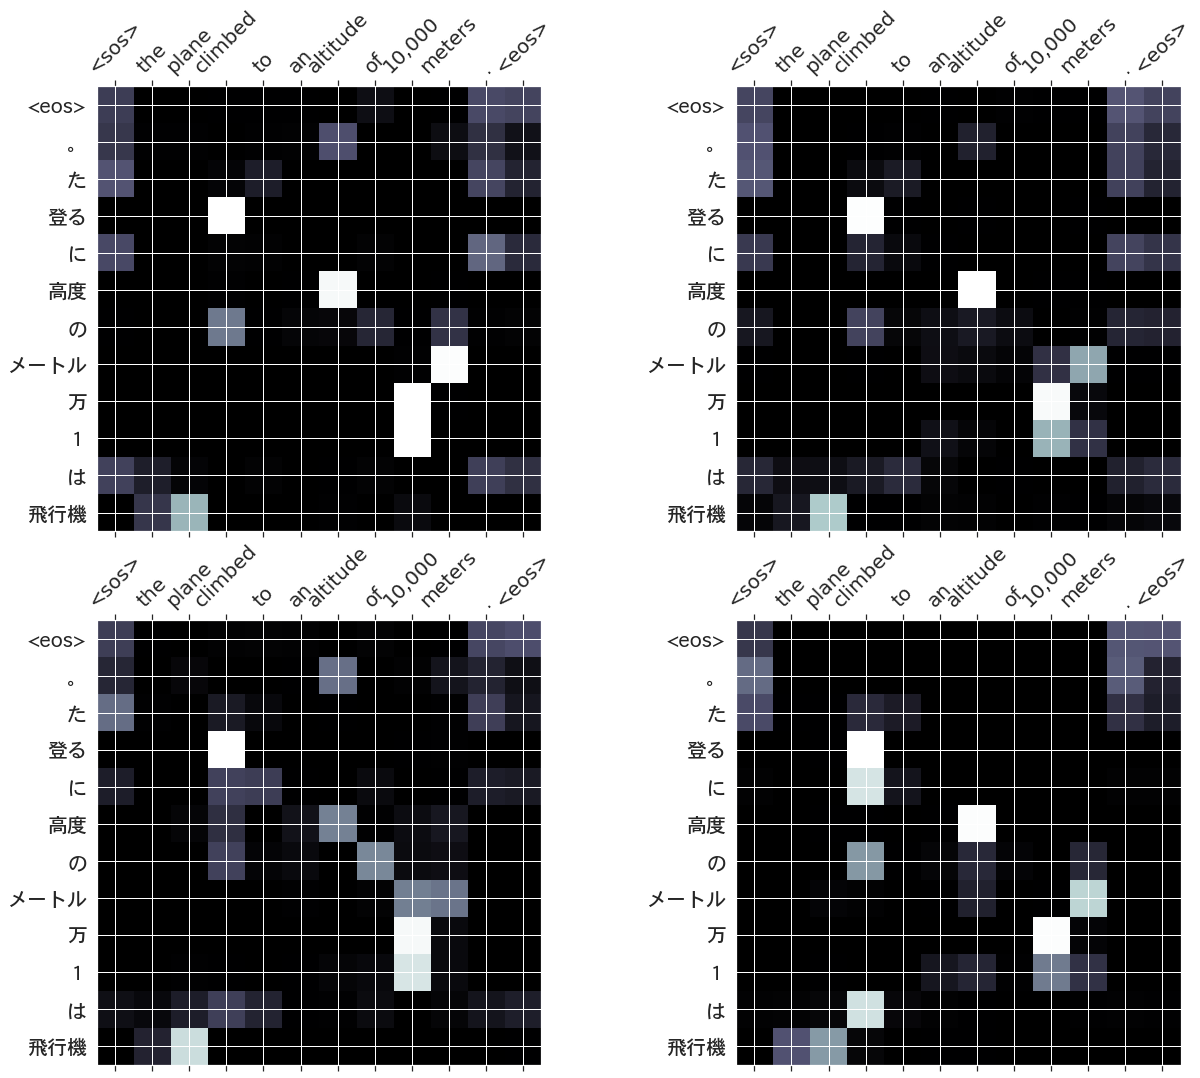

src      : he saved money for the trip .
trg      : 。 た 貯める を お金 に ため の 旅行 その は 彼
predicted: <eos> 。 た 救う を 金 ため の 旅行 は 彼
     blue: 91.47%


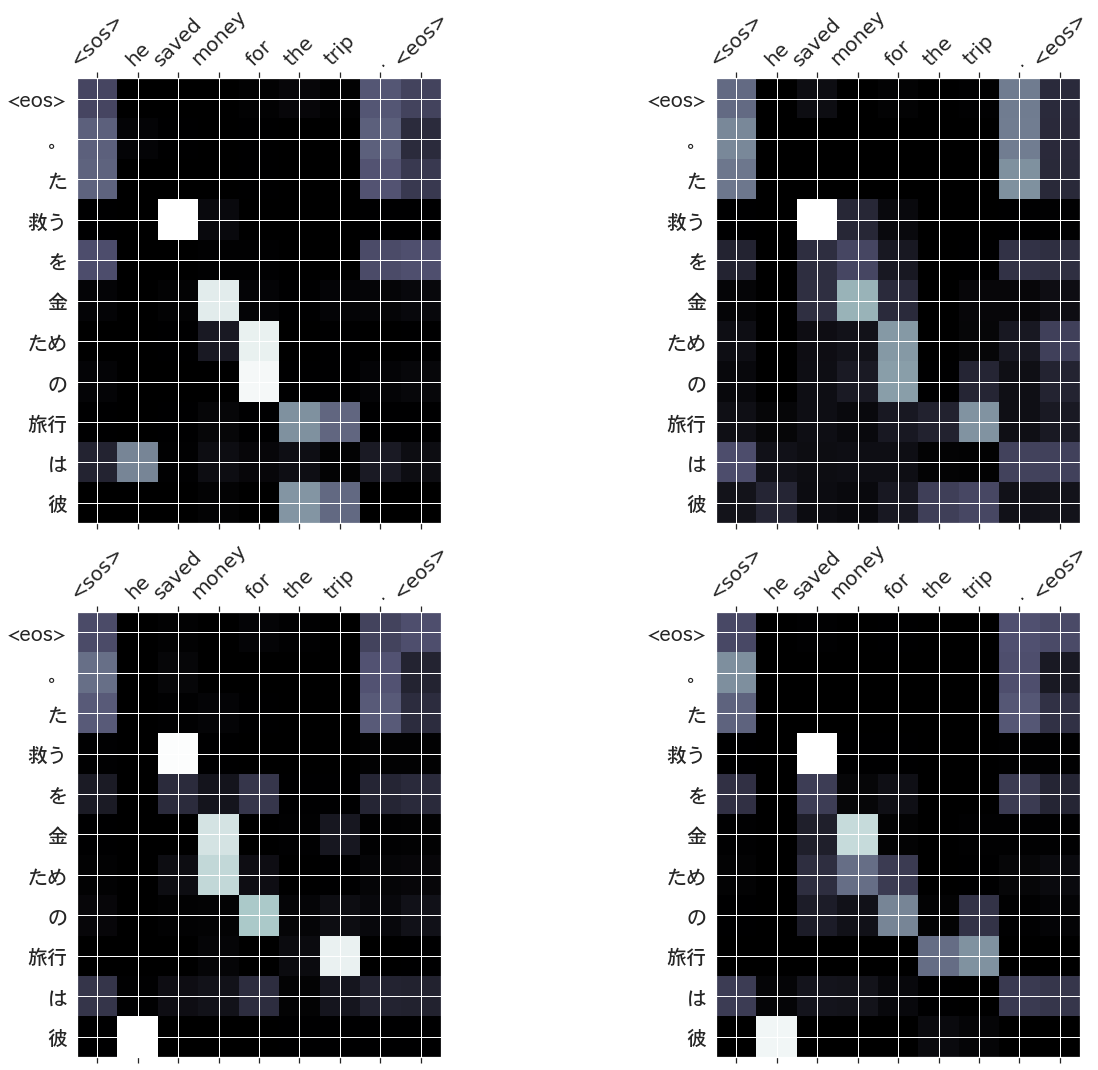

src      : i have never been to england .
trg      : 。 ん ます ある が こと た 行く へ イギリス は 私
predicted: <eos> 。 ない が こと た 行く へ イギリス は 私
     blue: 88.01%


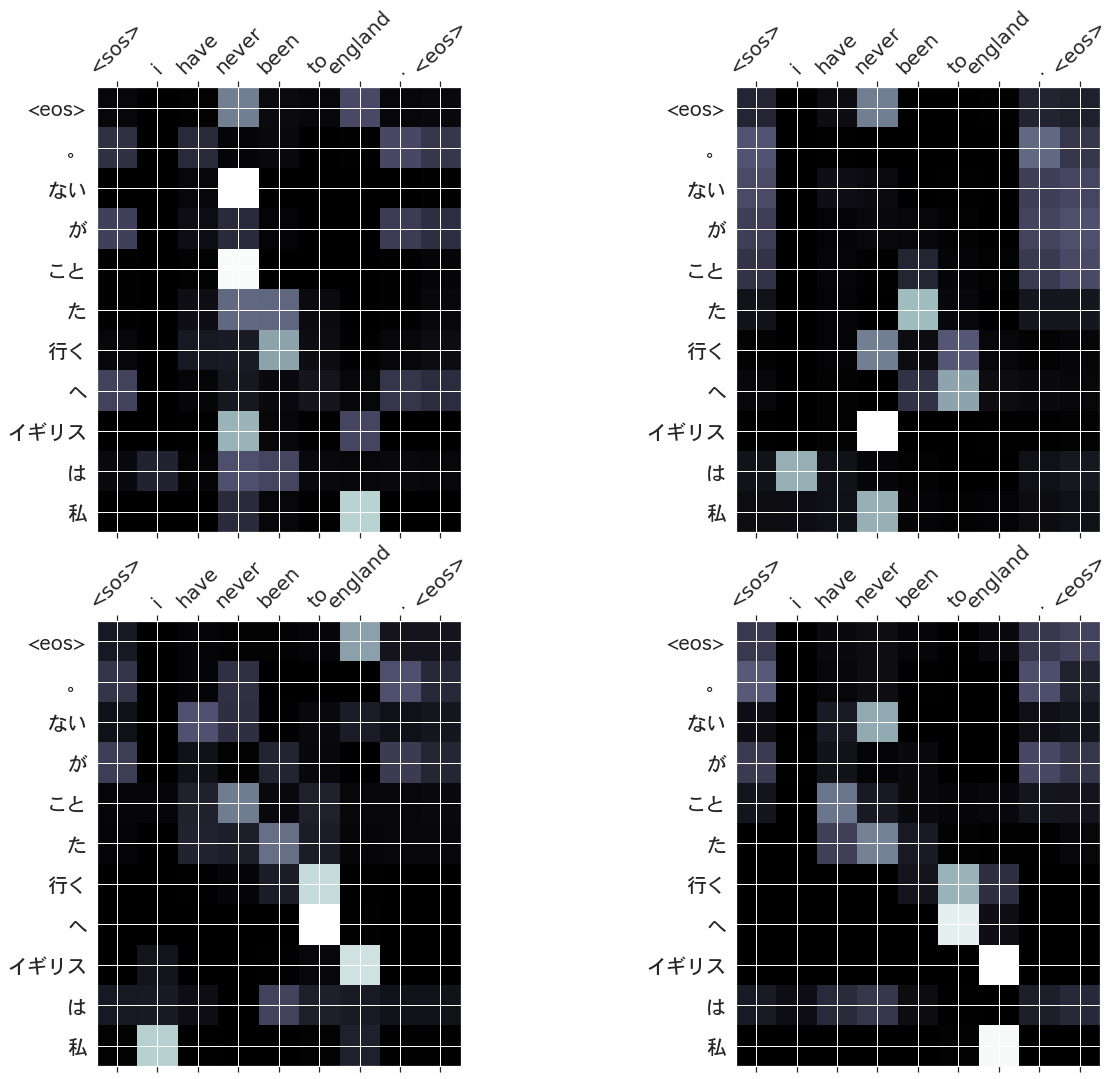

src      : the separation of gold from sand is problematic .
trg      : 。 だ 難問 は の より分ける を 金 から 砂
predicted: <eos> 。 だ <unk> から <unk> は <unk> の 金
     blue: 86.33%


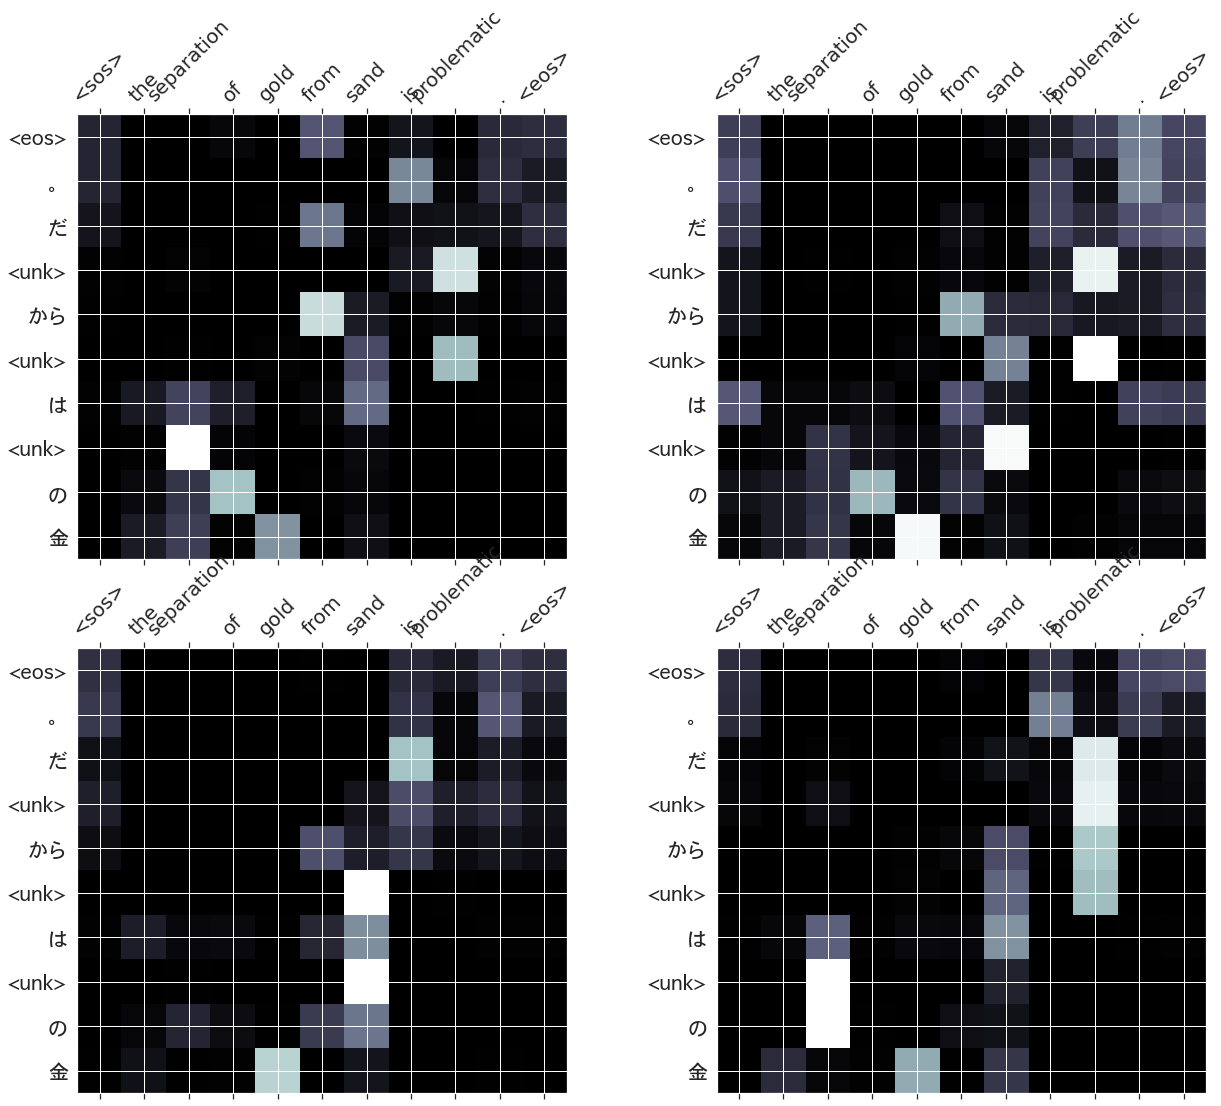

src      : he rested his hand on my shoulder .
trg      : 。 た 置く に 肩 の 私 を 手 は 彼
predicted: <eos> 。 た 向ける を 手 に 肩 の 私 は 彼
     blue: 97.65%


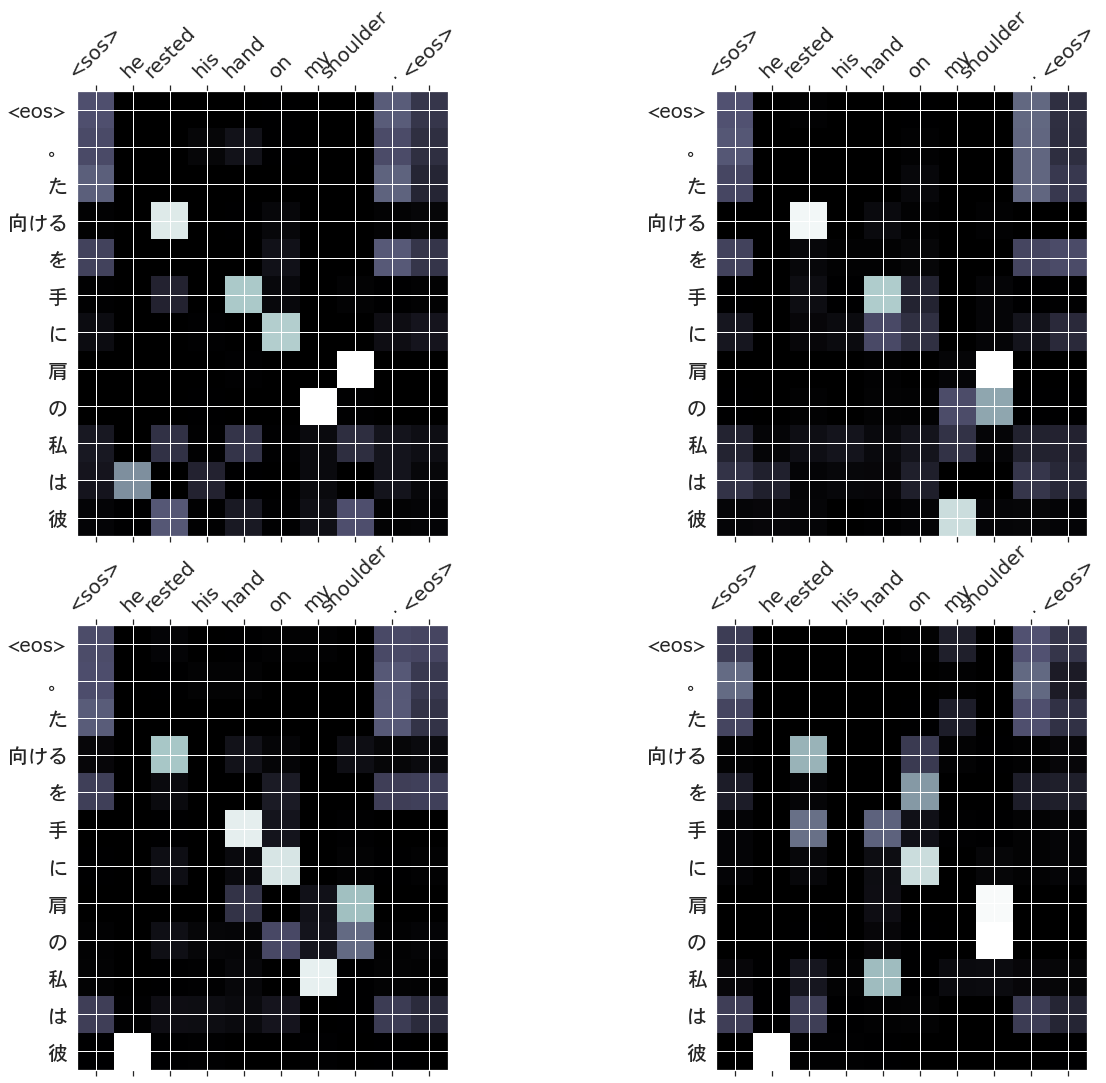

src      : he is familiar with four languages .
trg      : 。 いる て する 精通 に 語 か国 ４ は 彼
predicted: <eos> 。 いる て 知る を 語 カ国 ４ は 彼
     blue: 88.01%


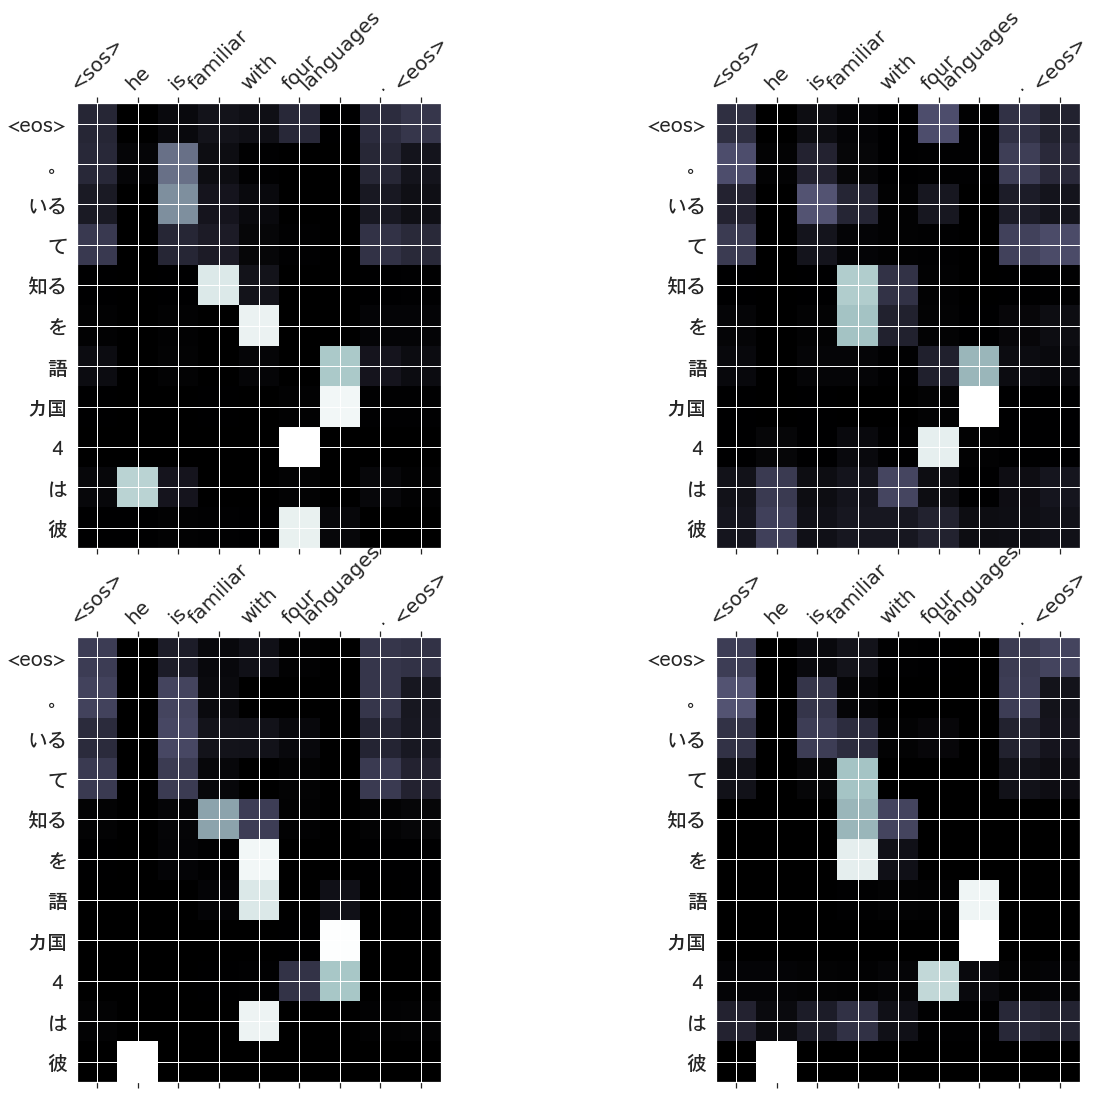

In [44]:
idxs = list(range(len(test_data)))
random.shuffle(idxs)

count = 0

for example_idx in idxs:
    example_idx = random.randint(0, 1219)
    src = vars(test_data.examples[example_idx])['src']
    trg = vars(test_data.examples[example_idx])['trg']
    translation, attention = translate_sentence(src, SRC, TRG, model, device, max_trg, src_tokenize)
    result = [translation[0]]
    
    blue = sentence_blue(trg, translation, 4)
    if blue < .85:
        continue


    for token in translation:
        if token != result[-1]:
            result.append(token)
    print(f'src      : {" ".join(src)}')
    print(f'trg      : {" ".join(trg[::-1])}')
    print(f'predicted: {" ".join(translation[::-1])}')
    print(f'     blue: {100 * blue:.2f}%')
    display_attention(src, translation, attention, n_heads = DEC_HEADS, n_rows = DEC_HEADS/2, n_cols = 2, fontprop_x=fontprop_x, fontprop_y=fontprop_y, reverse_trg=True)

    count += 1
    if count > 40:
        break